# pythia-features

Compare Pythia prefetchers against:
- Different feature sets 
- Different baseline prefetchers

Can do comparisons across:
- [Benchmark suites](#plots-suites)
- [Single becnhmarks](#plots-single-benchmarks)


In [1]:
from importlib import reload

from matplotlib import cm

from utils import plots, tables
#%matplotlib widget

In [2]:
# Knobs
paths = {
    # Max pooling, degree 1, 3 tilings
    'degree1_tiled_max': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_features.csv', 
    # Sum pooling, degree 1, 3 tilings
    'degree1_tiled_sum': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_features_sum.csv',
    # Max pooling, degree 1, 1 tiling (3x as large)
    'degree1_flat_max': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat.csv', 
    # Sum pooling, degree 1, 1 tiling (3x as large), unweighted sum
    'degree1_flat_sum': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum.csv', 
    # Weighted sum with global weights
    'degree1_flat_sum_weighted': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_weighted.csv',
    # Unweighted sum with bias term
    'degree1_flat_sum_biased': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_biased.csv',
    # Weighted sum with per-action weights
    'degree1_flat_sum_weighted_action': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_weighted_action.csv',
    # Weighted sum with normalized, per-action weights
    'degree1_flat_sum_normalized_action': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_normalized_action.csv',
    # Weighted sum with normalized, per-action weights + larger gradient (0.01), minimum weight (0.01)
    'degree1_flat_sum_normalizedplus_action': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_normalizedplus_action.csv',
    # Weighted sum with per-state weights
    'degree1_flat_sum_weighted_state': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_weighted_state.csv',
    # Weighted sum with per-state-action weights
    'degree1_flat_sum_weighted_stateaction': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_weighted_stateaction.csv',
    # Baselines (e.g. BO)
    'degree1_baseline': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_features.csv',
}

suites = [
    #('spec06', 'one_phase'),
    ('spec06', 'weighted'),
    #('gap', 'one_phase')
]
metrics  = [
    'ipc_improvement', 
    'L2C_issued_prefetches', 
    'L2C_accuracy', 
    'L2C_coverage',
    #'L2C_mpki_reduction', 
]
single_features = [
    {'PC'},
    {'Offset'},
    {'Delta'},
    {'Address'},
    {'PC_Address'},
    {'Delta_Path'},
    {'PC_Delta'},
    {'Page'},
]
multi_features = [
    {'Delta_Path', 'PC_Delta'},
    {'Delta_Path', 'PC_Delta', 'Page'},
    {'Delta_Path', 'PC_Delta', 'Page', 'Offset'},
]
baselines = [
    'bo', 'spp_dev2', 'bingo'
]
dpi = 150

# Plots (suites)
Fix prefetch degree to 1 for everything.

In [3]:
dfs = {
    'degree1_baseline': tables.load_stats_csv(paths['degree1_baseline'], baselines, prefetchers_level='l2'),
    'degree1_tiled_max': tables.load_stats_csv_pythia(paths['degree1_tiled_max'], single_features + multi_features),
    'degree1_tiled_sum': tables.load_stats_csv_pythia(paths['degree1_tiled_sum'], multi_features),
    'degree1_flat_max': tables.load_stats_csv_pythia(paths['degree1_flat_max'], multi_features),
    'degree1_flat_sum': tables.load_stats_csv_pythia(paths['degree1_flat_sum'], multi_features),
    'degree1_flat_sum_biased': tables.load_stats_csv_pythia(paths['degree1_flat_sum_biased'], multi_features),
    'degree1_flat_sum_weighted': tables.load_stats_csv_pythia(paths['degree1_flat_sum_weighted'], multi_features),
    'degree1_flat_sum_weighted_action': tables.load_stats_csv_pythia(paths['degree1_flat_sum_weighted_action'], multi_features),
    'degree1_flat_sum_normalized_action': tables.load_stats_csv_pythia(paths['degree1_flat_sum_normalized_action'], multi_features),
    'degree1_flat_sum_normalizedplus_action': tables.load_stats_csv_pythia(paths['degree1_flat_sum_normalizedplus_action'], multi_features),
    'degree1_flat_sum_weighted_state': tables.load_stats_csv_pythia(paths['degree1_flat_sum_weighted_state'], multi_features),
    'degree1_flat_sum_weighted_stateaction': tables.load_stats_csv_pythia(paths['degree1_flat_sum_weighted_stateaction'], multi_features),
}

/u/cmolder/GitHub/pythia-analysis/utils/utils.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.filter(regex='simpoint').fillna('default', inplace=True)
/u/cmolder/GitHub/pythia-analysis/utils/utils.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.filter(regex='simpoint').fillna('default', inplace=True)
/u/cmolder/GitHub/pythia-analysis/utils/utils.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.filter(regex='simpo

## Baselines

### mix1 vs. BO, SPP, Bingo

/u/cmolder/GitHub/pythia-analysis/utils/stats.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row)
/u/cmolder/GitHub/pythia-analysis/utils/stats.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row)
/u/cmolder/GitHub/pythia-analysis/utils/stats.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row)
/u/cmolder/GitHub/pythia-analysis/utils/stats.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row)


=== spec06 weighted ===


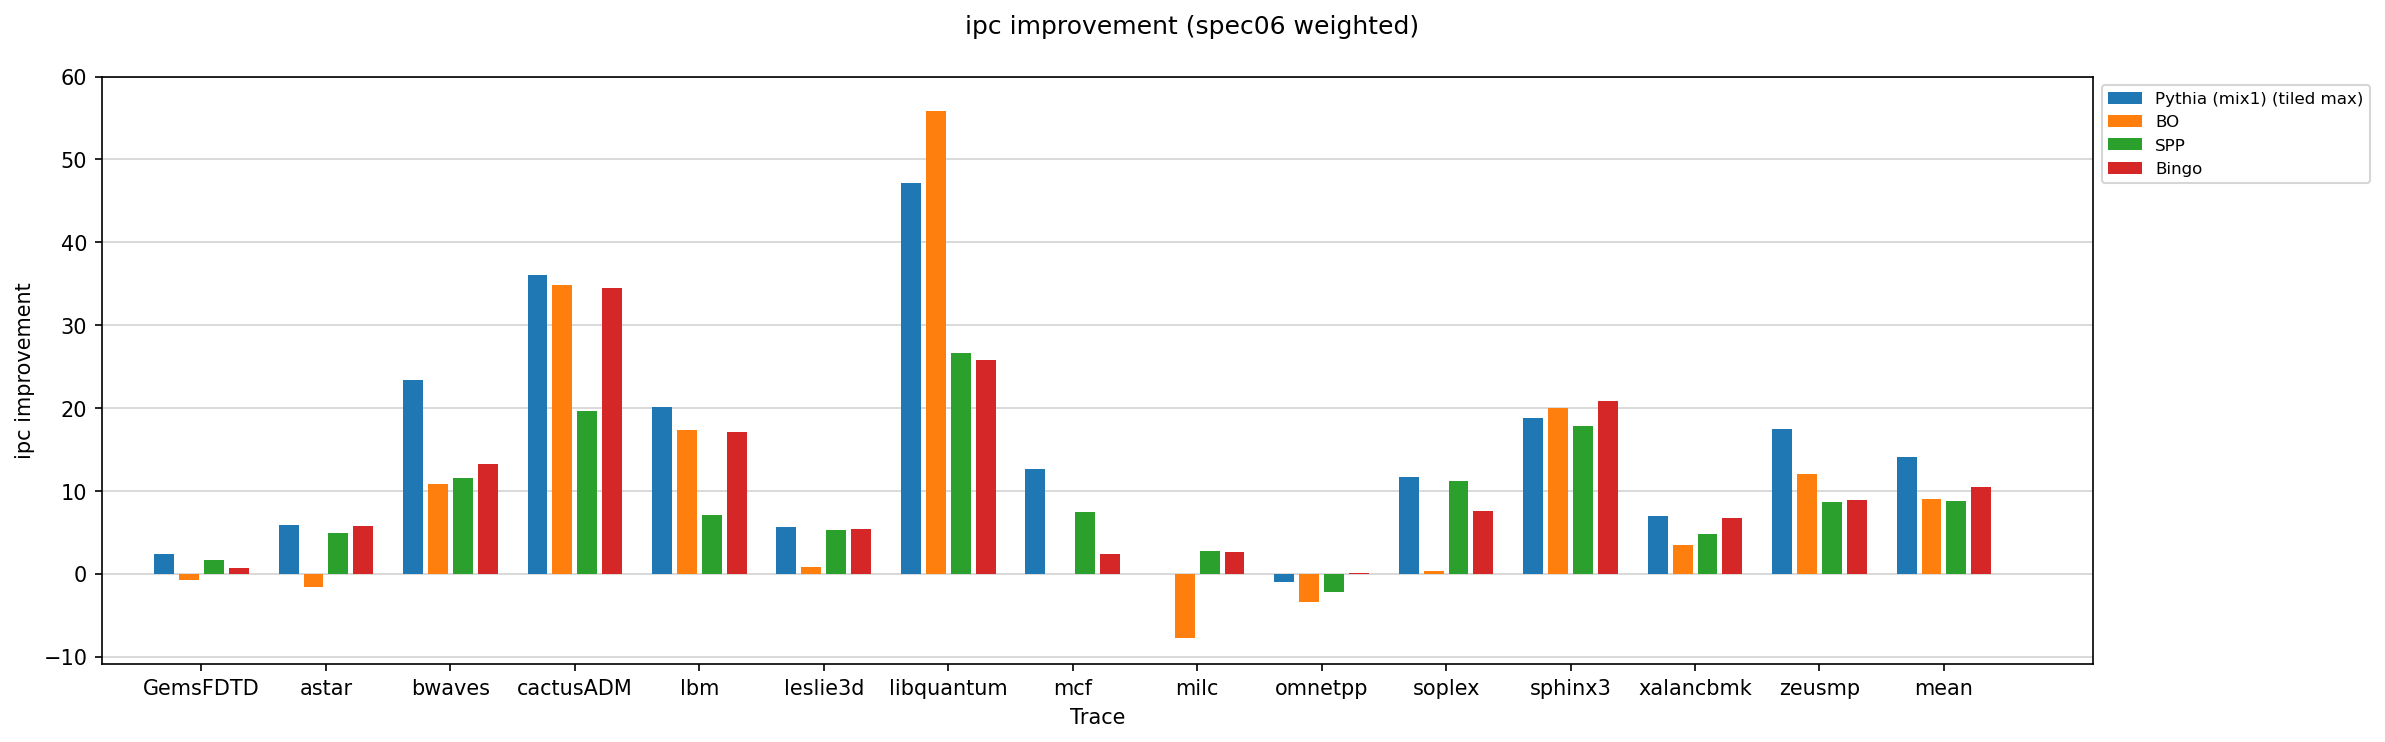

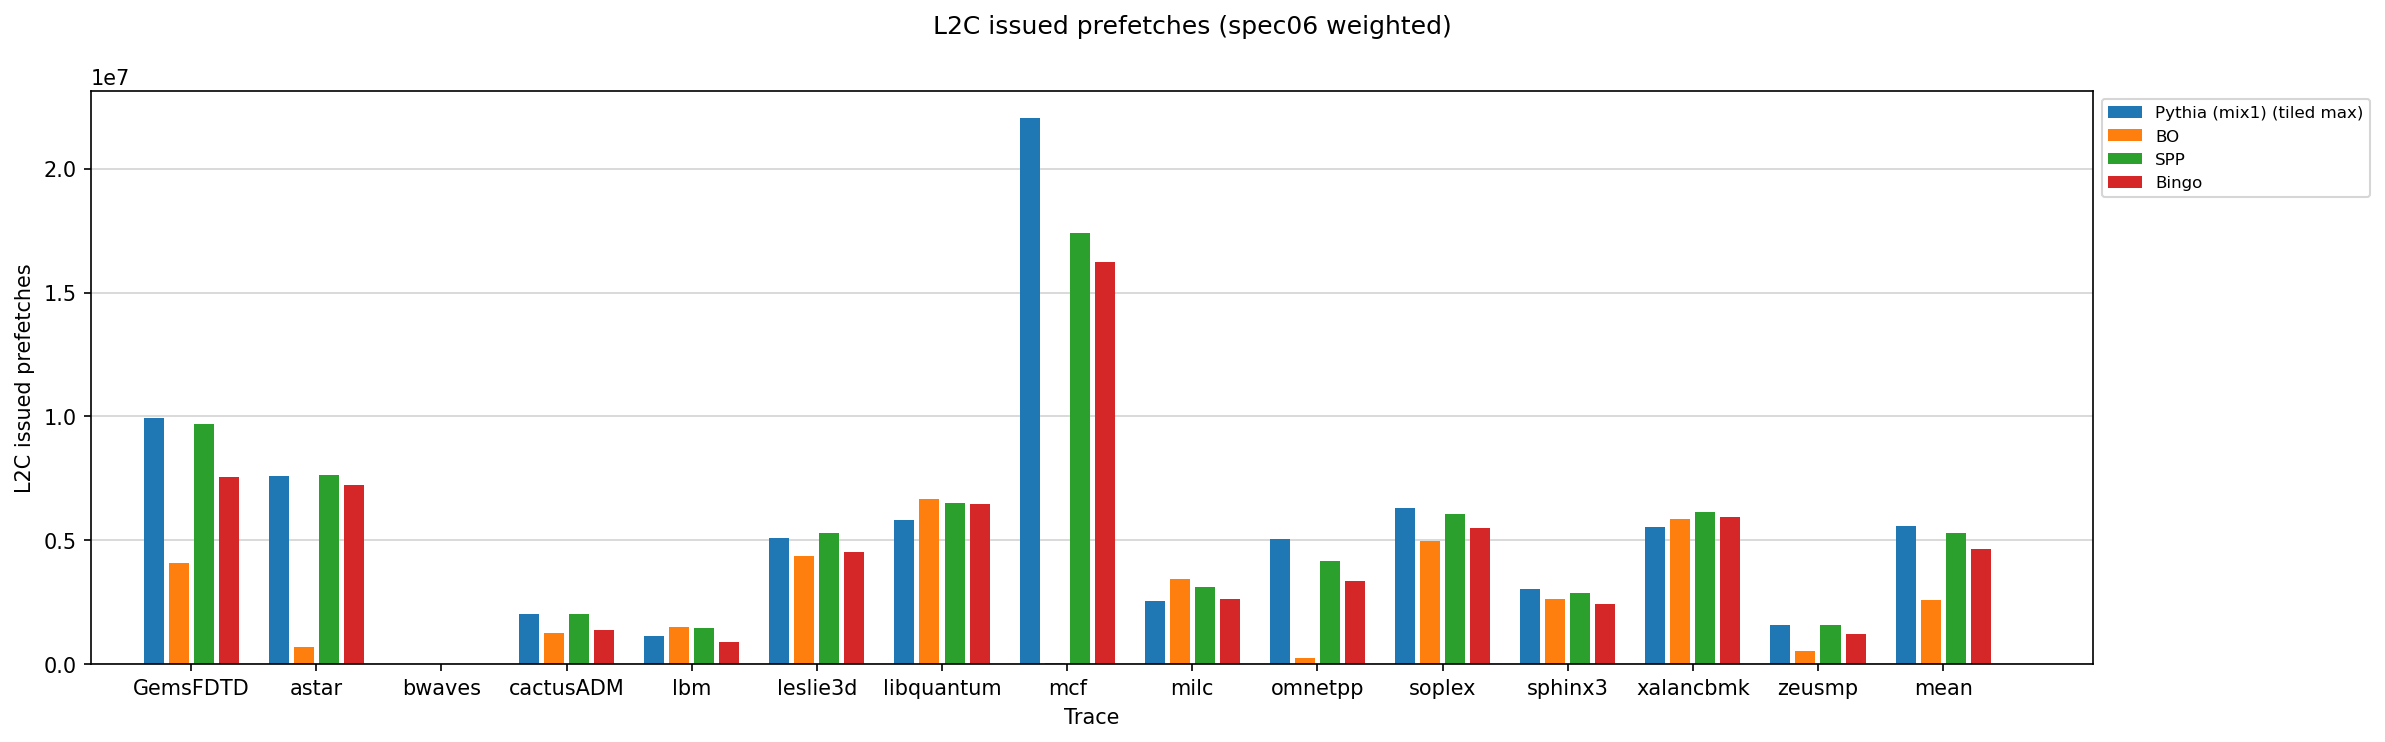

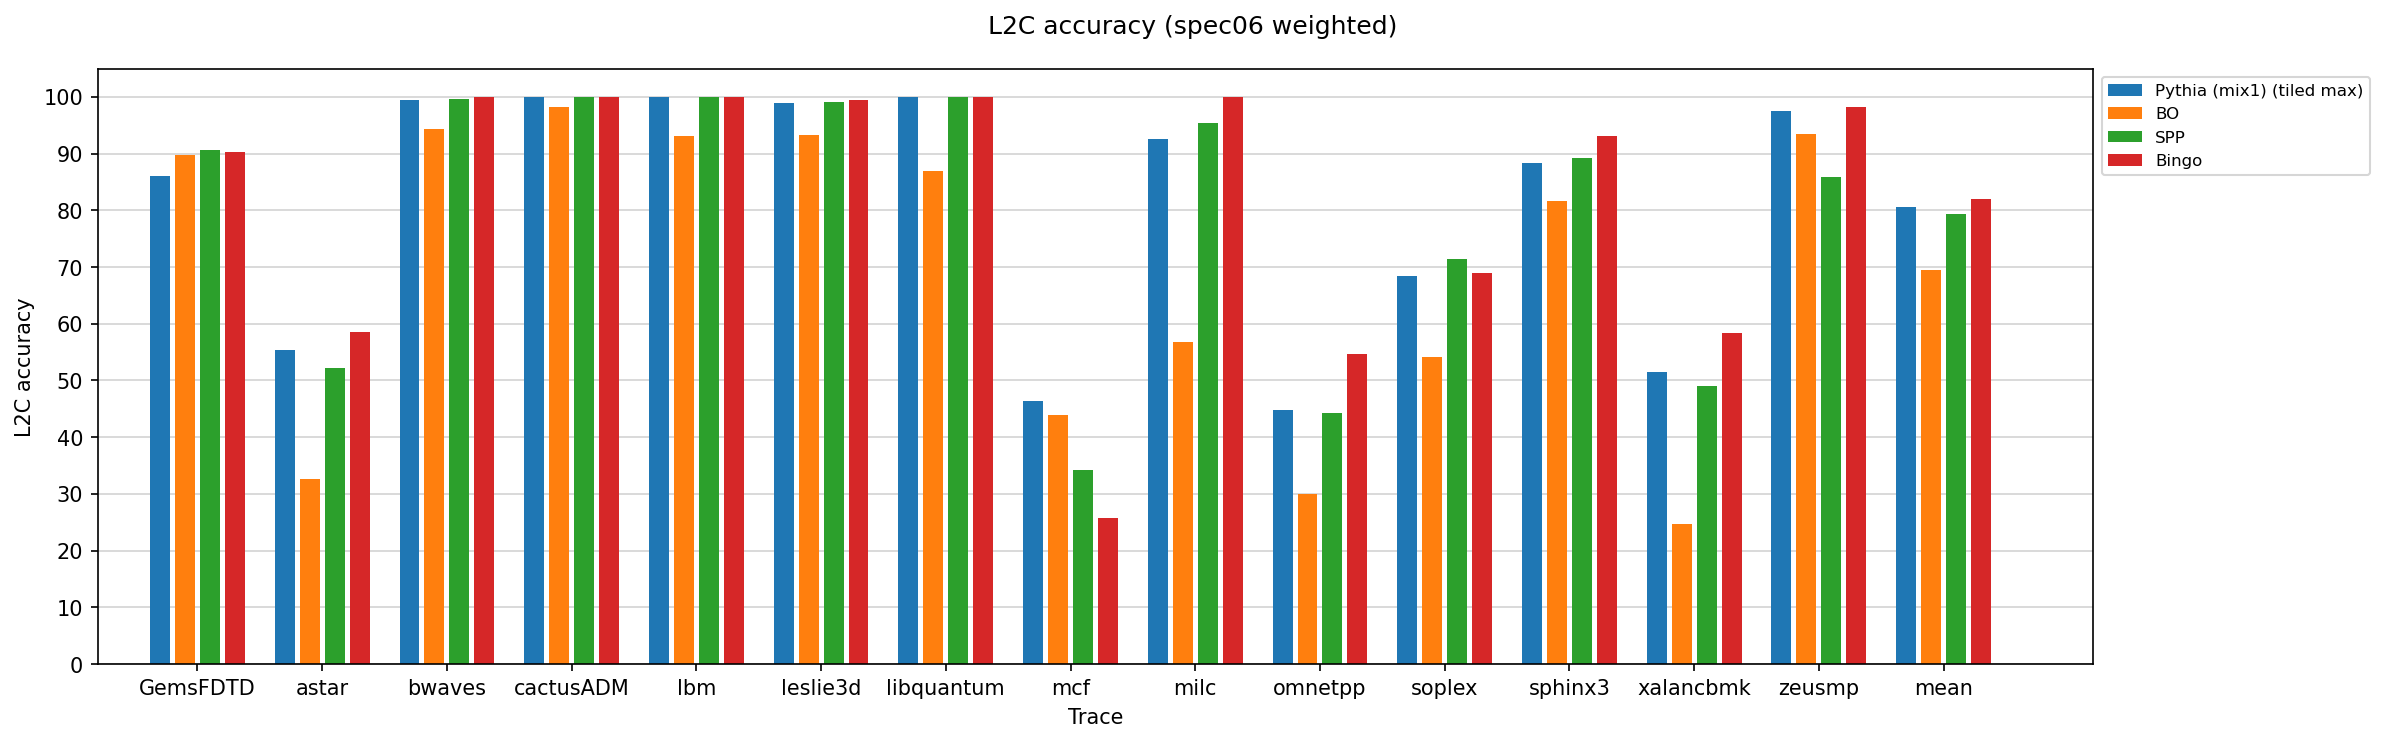

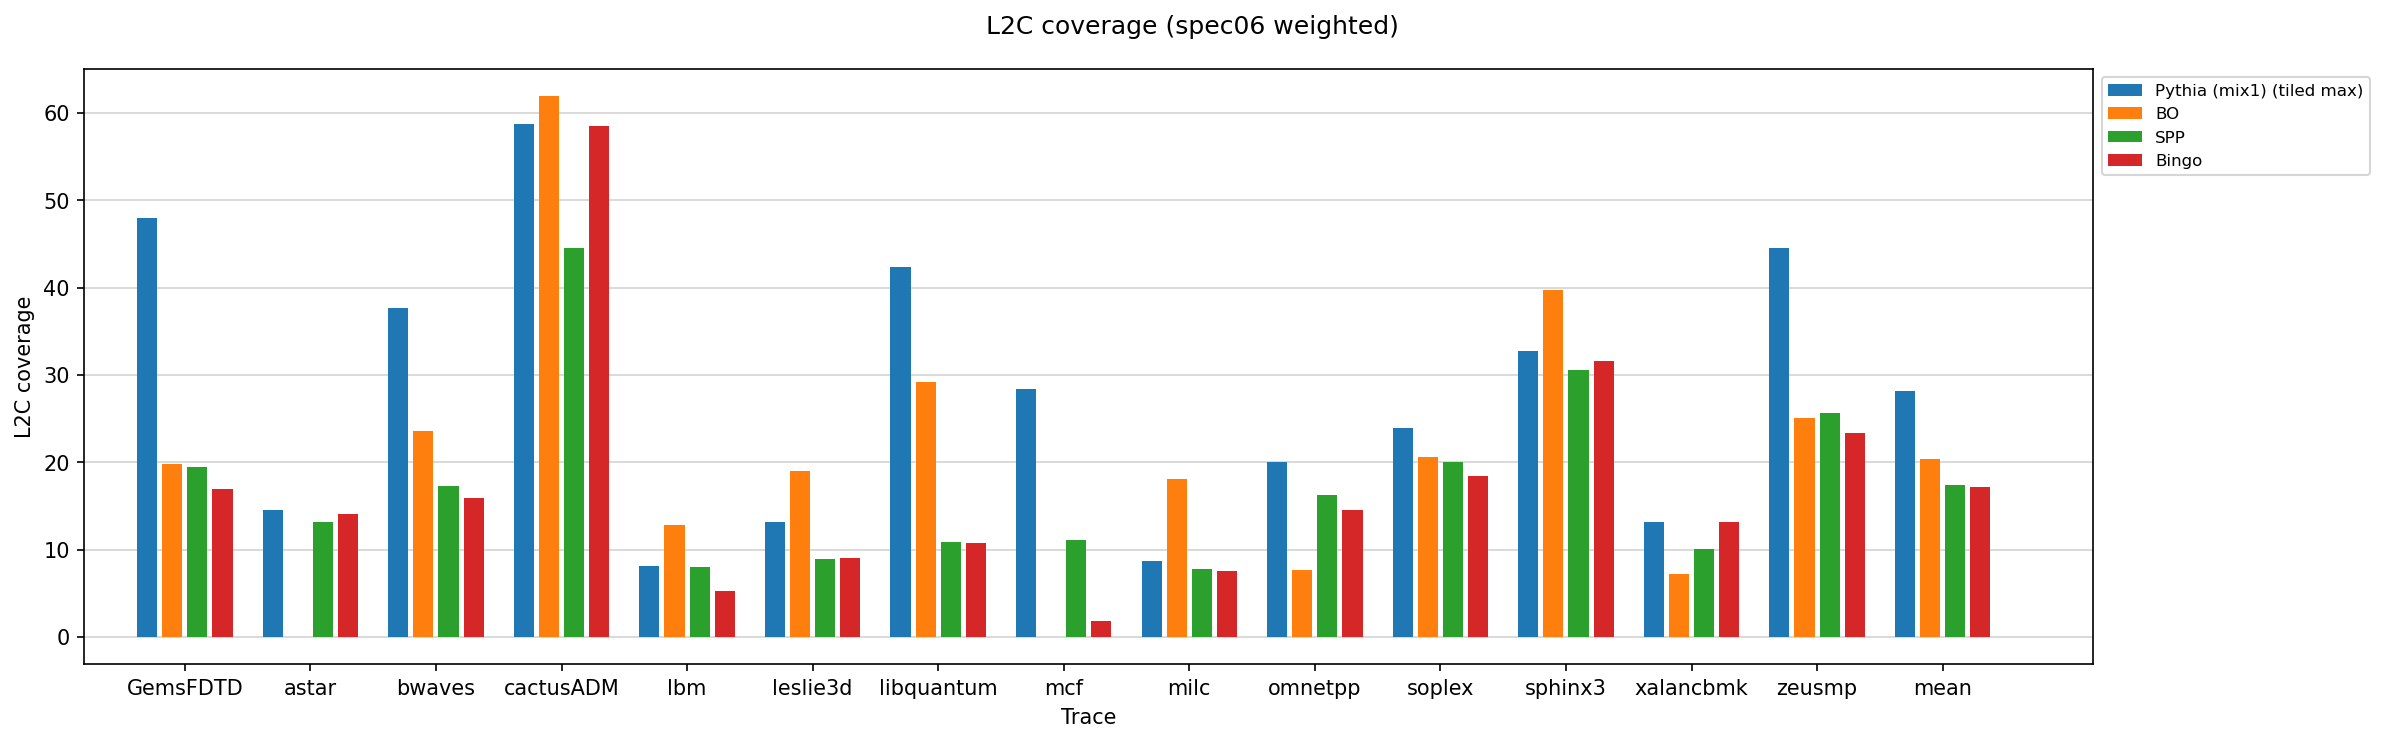

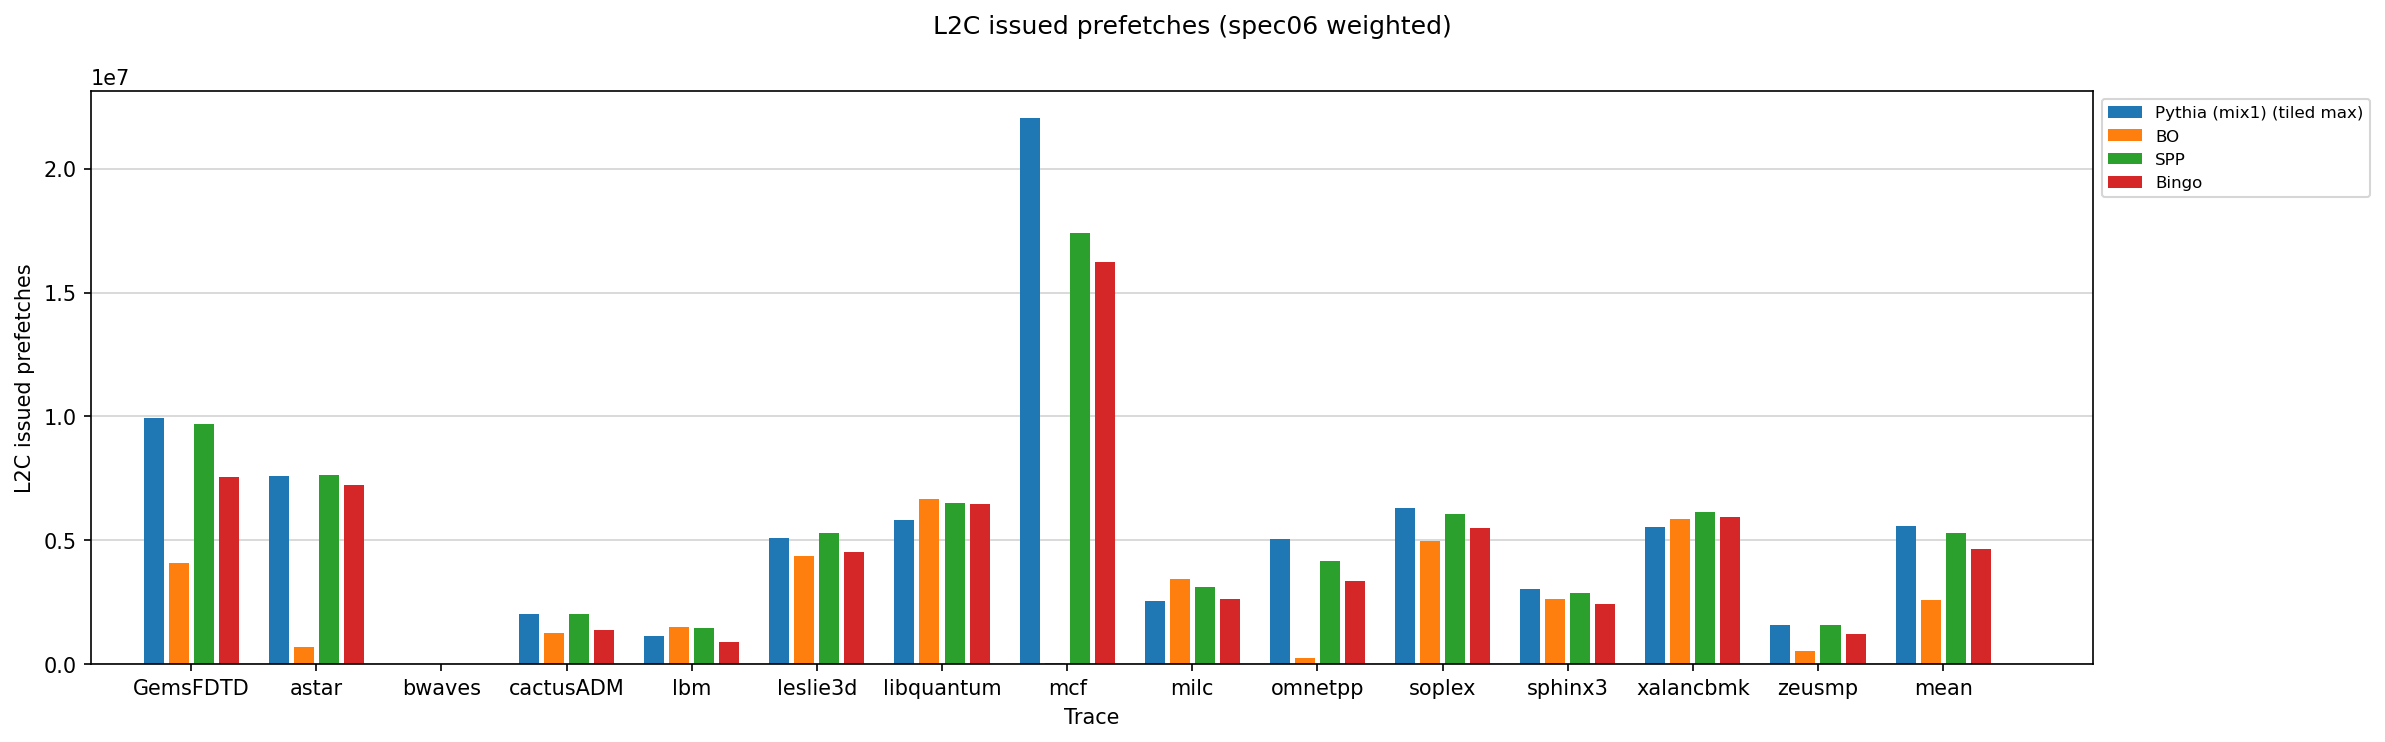

In [4]:
baselines_df = {
    'Pythia (mix1) (tiled max)': dfs['degree1_tiled_max']['Delta_Path, PC_Delta'],
    'BO': dfs['degree1_baseline']['bo'],
    'SPP': dfs['degree1_baseline']['spp_dev2'],
    'Bingo': dfs['degree1_baseline']['bingo']
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    'loc': 'upper left',
    'bbox_to_anchor': (1, 1),
}
label_kwargs = {
    'fontsize': 8,
    'rotation': 0
}
plots.plot_everything(baselines_df, suites=suites, metrics=metrics + ['L2C_issued_prefetches'], 
                      legend_kwargs=legend_kwargs, dpi=dpi, figsize=(16,5))

## Pythia features (max pooling)

*Note*: Max pooling = Sum pooling when only one feature is used.

=== spec06 weighted ===


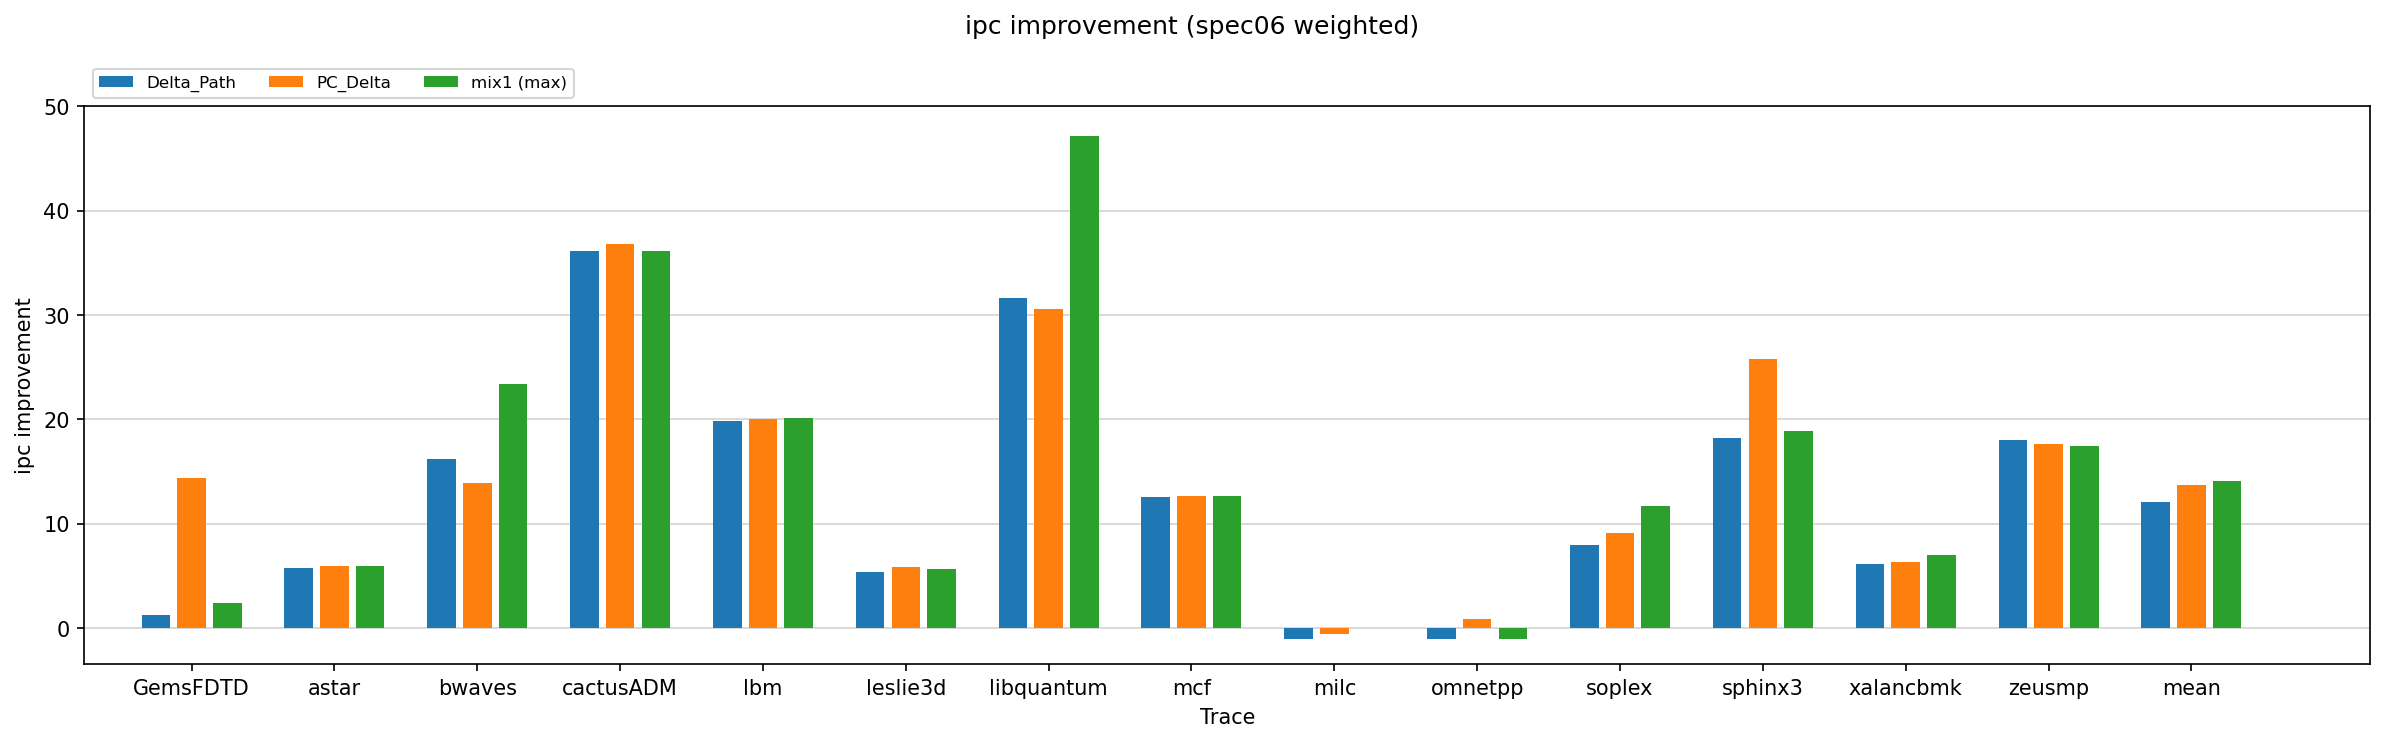

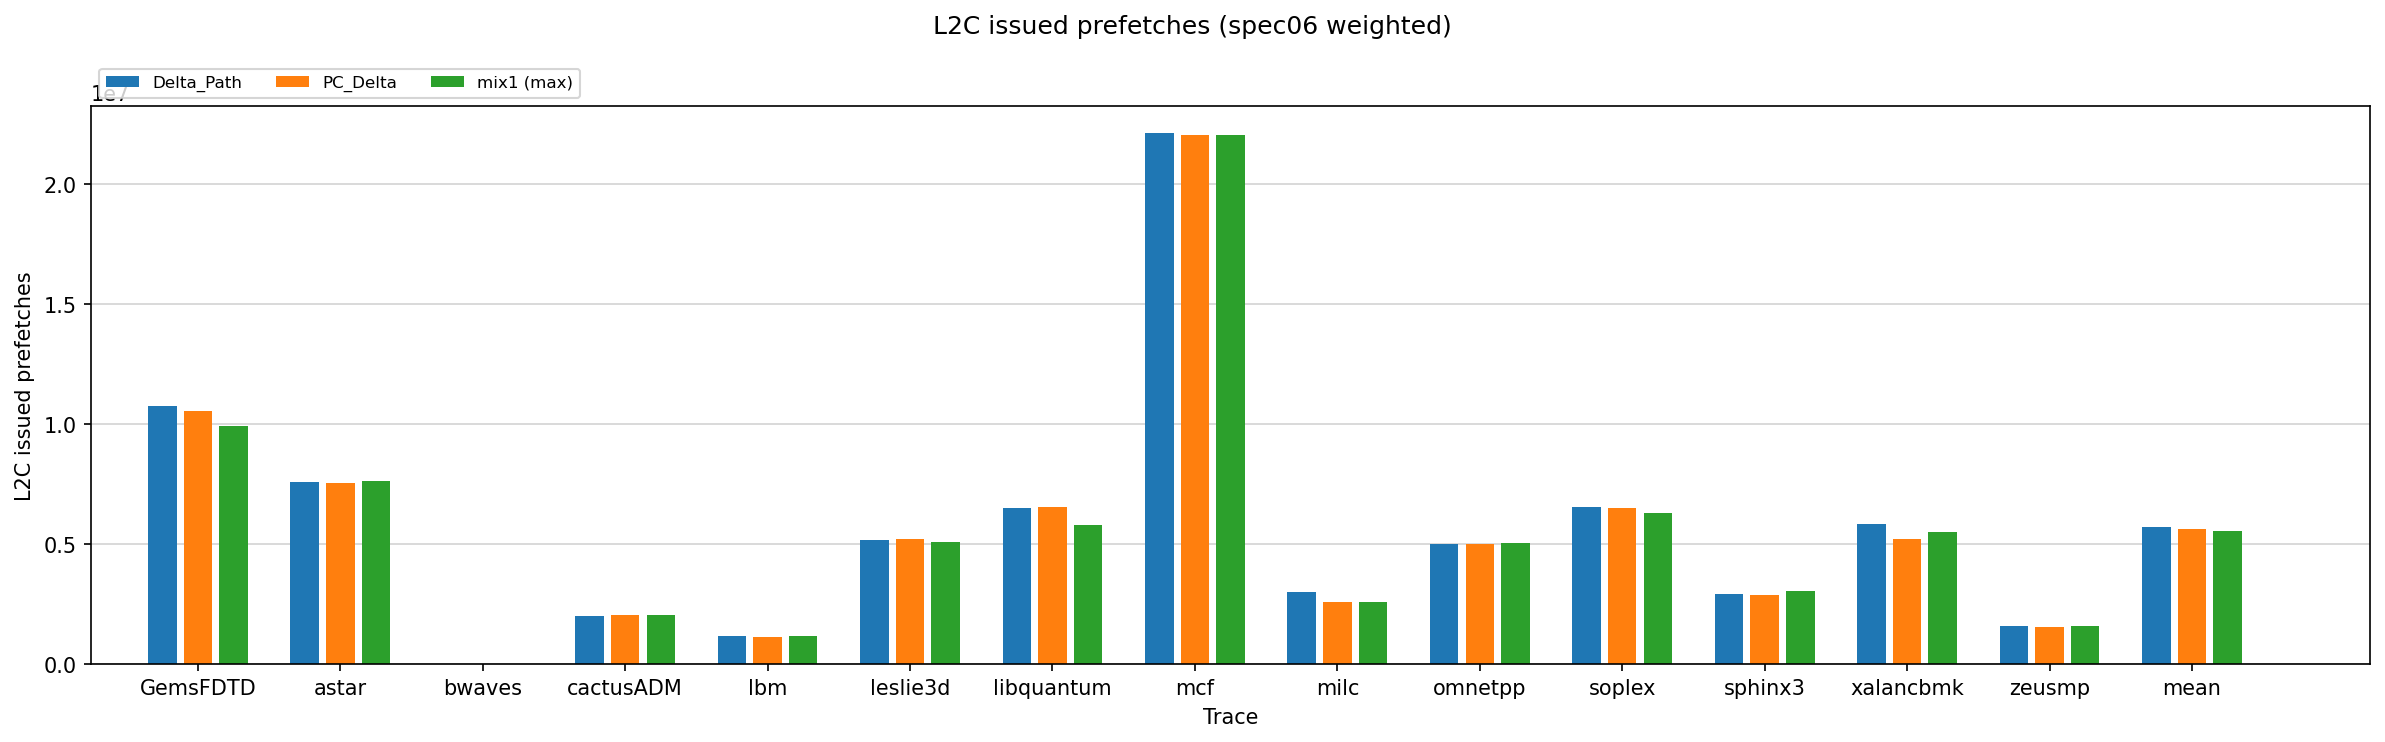

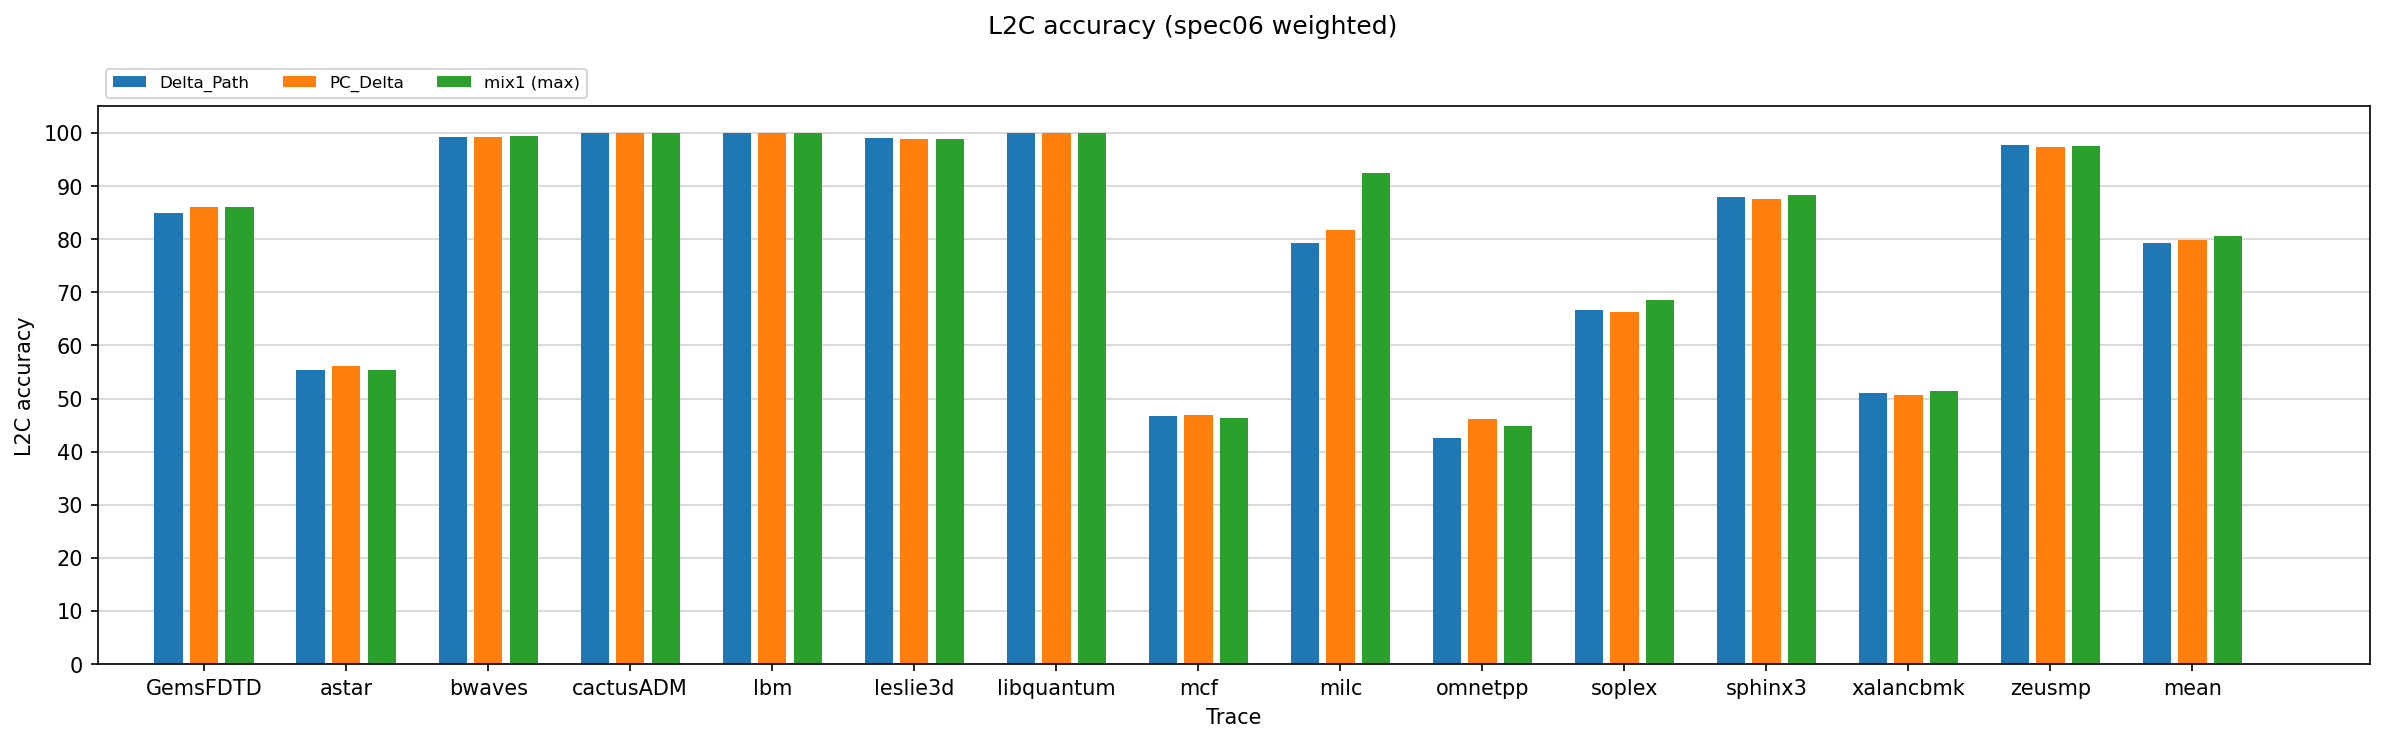

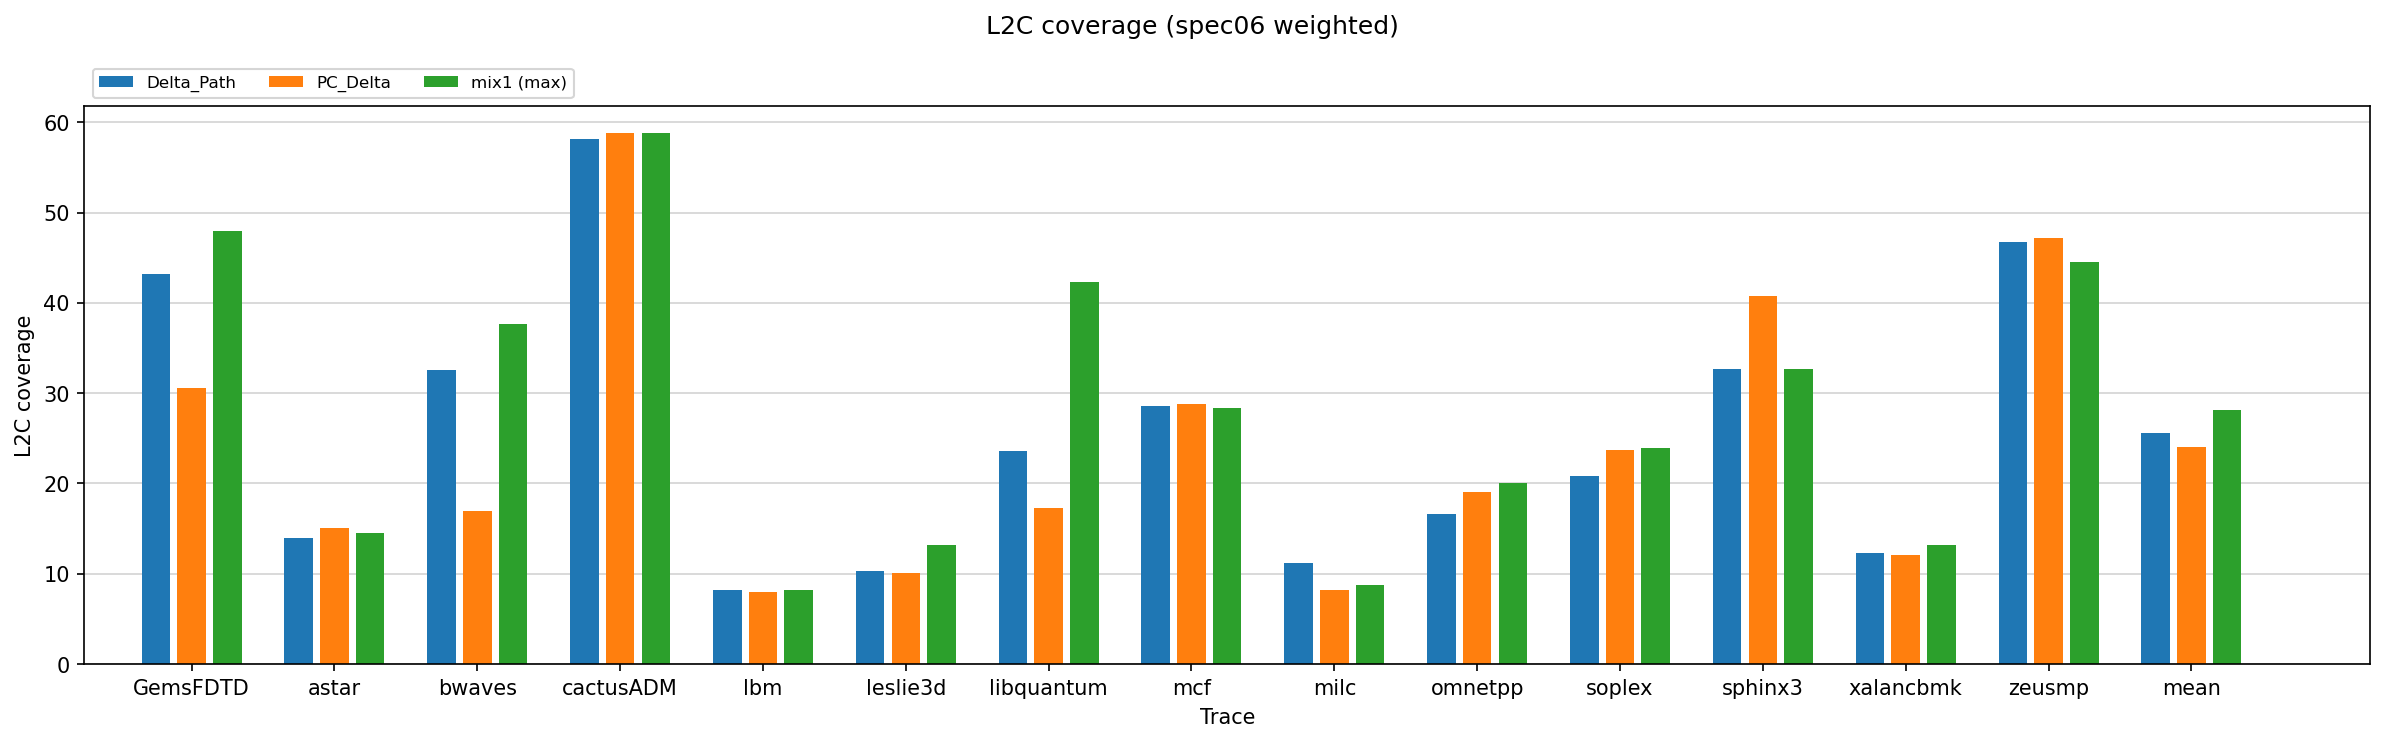

In [13]:
max_pool_df = {
    # 'Offset': dfs['degree1_tiled_max']['Offset'],
    # 'Delta': dfs['degree1_tiled_max']['Delta'],
    # 'Address': dfs['degree1_tiled_max']['Address'],
    # 'PC_Address': dfs['degree1_tiled_max']['PC_Address'],
    # 'Page': dfs['degree1_tiled_max']['Page'],
    'Delta_Path': dfs['degree1_tiled_max']['Delta_Path'],
    # 'PC': dfs['degree1_tiled_max']['PC'],
    'PC_Delta': dfs['degree1_tiled_max']['PC_Delta'],
    'mix1 (max)': dfs['degree1_tiled_max']['Delta_Path, PC_Delta'],
    # 'mix2 (max)': dfs['degree1_tiled_max']['Delta_Path, PC_Delta, Page'],
    # 'mix3 (max)': dfs['degree1_tiled_max']['Delta_Path, Offset, PC_Delta, Page'],
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 11,
    'loc': 'lower left',
    'bbox_to_anchor': (0, 1),
}
plots.plot_everything(max_pool_df, suites=suites, metrics=metrics, 
                      legend_kwargs=legend_kwargs, dpi=dpi, figsize=(16,5))

## Pythia features (sum pooling)

=== spec06 one_phase ===


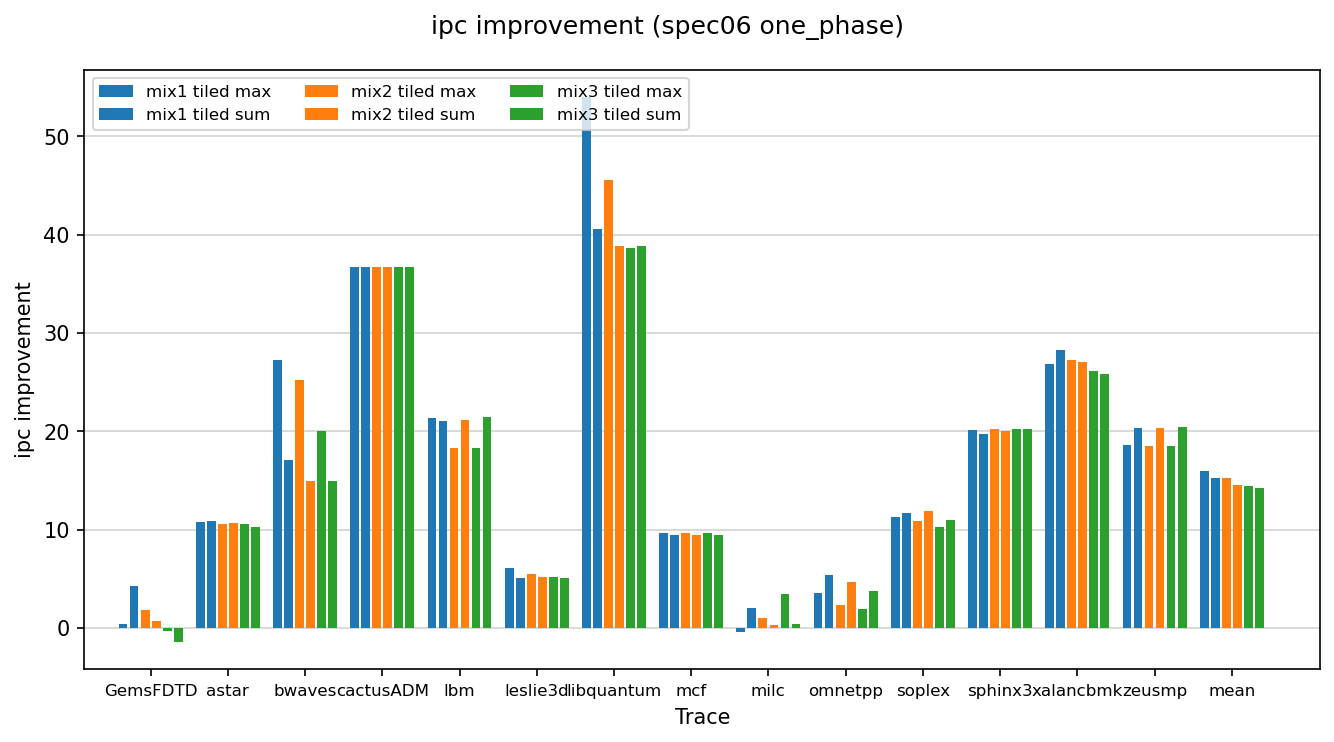

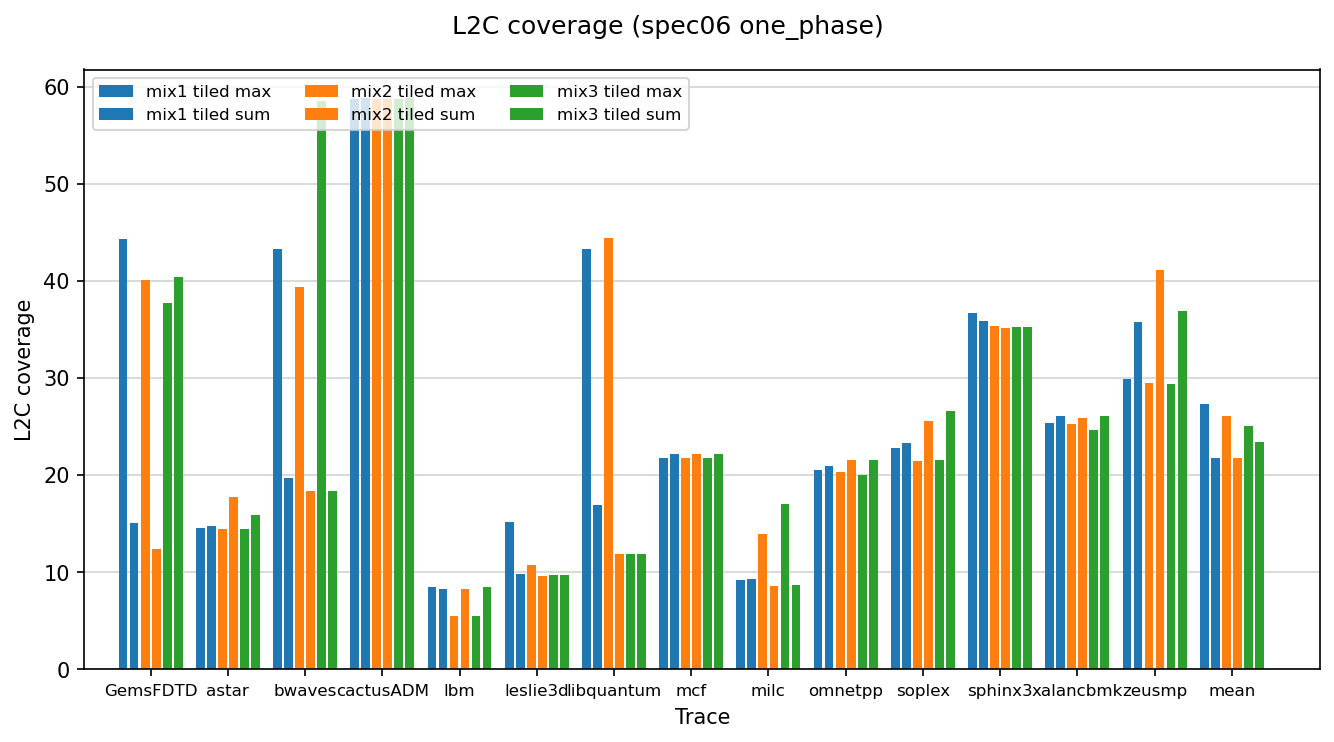

In [13]:
sum_pool_df = {
    'mix1 tiled max': dfs['degree1_tiled_max']['Delta_Path, PC_Delta'],
    'mix1 tiled sum': dfs['degree1_tiled_sum']['Delta_Path, PC_Delta'],
    'mix2 tiled max': dfs['degree1_tiled_max']['Delta_Path, PC_Delta, Page'],
    'mix2 tiled sum': dfs['degree1_tiled_sum']['Delta_Path, PC_Delta, Page'],
    'mix3 tiled max': dfs['degree1_tiled_max']['Delta_Path, Offset, PC_Delta, Page'],
    'mix3 tiled sum': dfs['degree1_tiled_sum']['Delta_Path, Offset, PC_Delta, Page'],
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 3,
    'loc': 'upper left',
    'bbox_to_anchor': (0, 1),
}
sum_pool_df_colors = {
    'mix1 tiled max': 'C0',
    'mix1 tiled sum': 'C0',
    'mix2 tiled max': 'C1',
    'mix2 tiled sum': 'C1',
    'mix3 tiled max': 'C2',
    'mix3 tiled sum': 'C2',
}
label_kwargs = {
    'fontsize': 8,
    'rotation': 0
}
plots.plot_everything(sum_pool_df, suites=suites, metrics=metrics, colors=sum_pool_df_colors,
                      legend_kwargs=legend_kwargs, label_kwargs=label_kwargs, dpi=dpi, figsize=(9,5))

## Pythia features (Various mixes vs. BO)

### mix1: Delta_Path, PC_Delta

#### Tiled vs. flat

=== spec06 one_phase ===


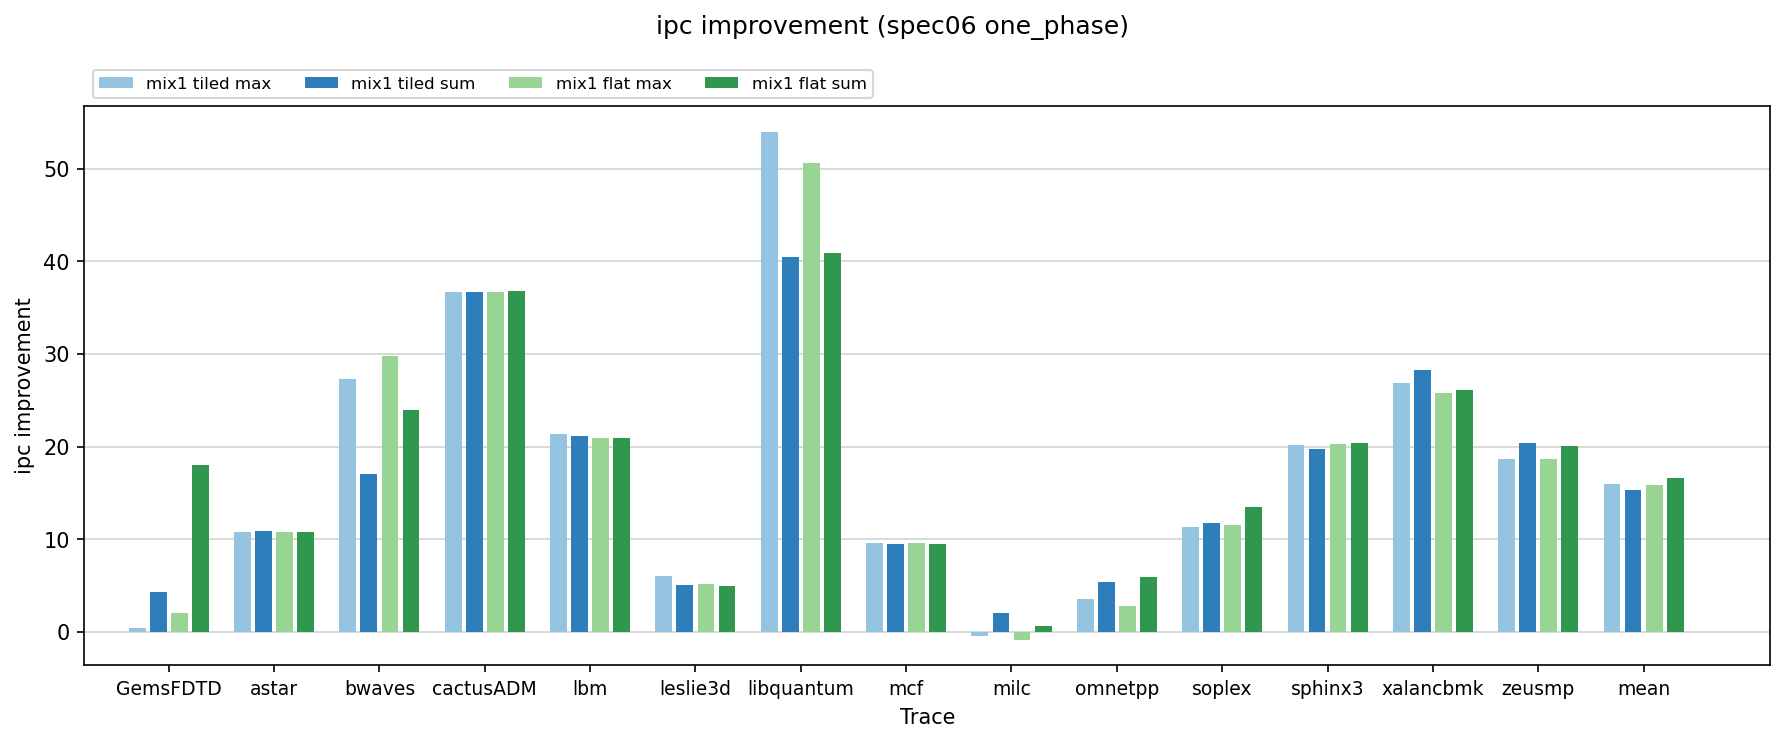

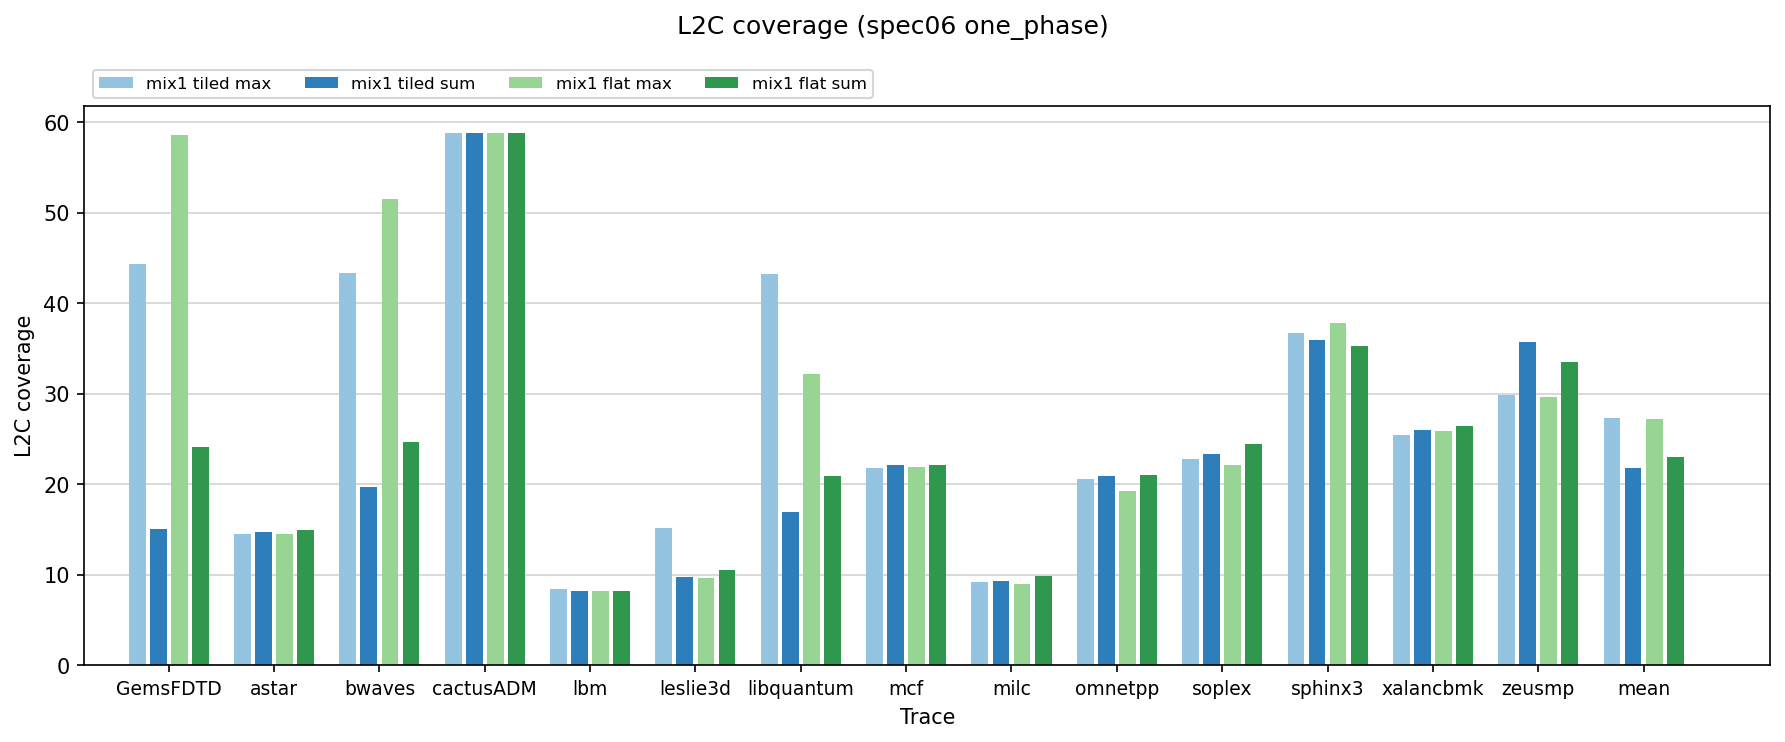

In [20]:
reload(plots)
tiled_cmap = cm.get_cmap('Blues')
flat_cmap = cm.get_cmap('Greens')
mix = 'Delta_Path, PC_Delta'
mix1_tiled_df = {
    'mix1 tiled max': dfs['degree1_tiled_max'][mix],
    'mix1 tiled sum': dfs['degree1_tiled_sum'][mix],
    'mix1 flat max': dfs['degree1_flat_max'][mix],
    'mix1 flat sum': dfs['degree1_flat_sum'][mix],
}
mix1_tiled_df_colors = {
    'mix1 tiled max': tiled_cmap(0.4),
    'mix1 tiled sum': tiled_cmap(0.7),
    'mix1 flat max': flat_cmap(0.4),
    'mix1 flat sum': flat_cmap(0.7),
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 4,
    'loc': 'lower left',
    'bbox_to_anchor': (0, 1),
}
label_kwargs = {
    'fontsize': 9,
    'rotation': 0
}
plots.plot_everything(mix1_tiled_df, suites=suites, metrics=metrics, 
                      colors=mix1_tiled_df_colors, dpi=dpi, figsize=(12, 5),
                      legend_kwargs=legend_kwargs, label_kwargs=label_kwargs)

#### Pooling tweaks

=== spec06 weighted ===


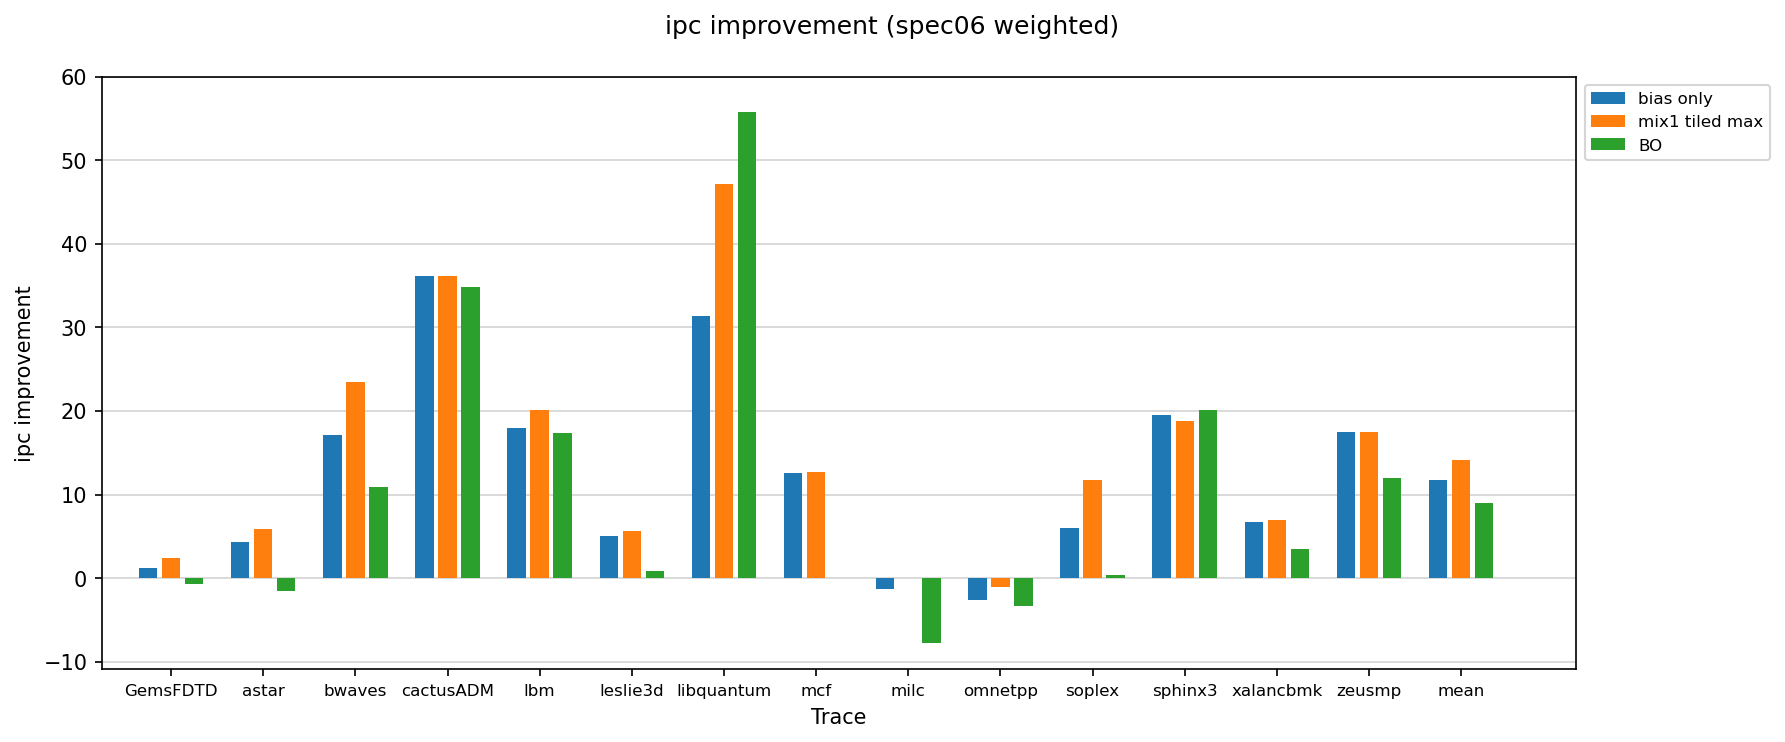

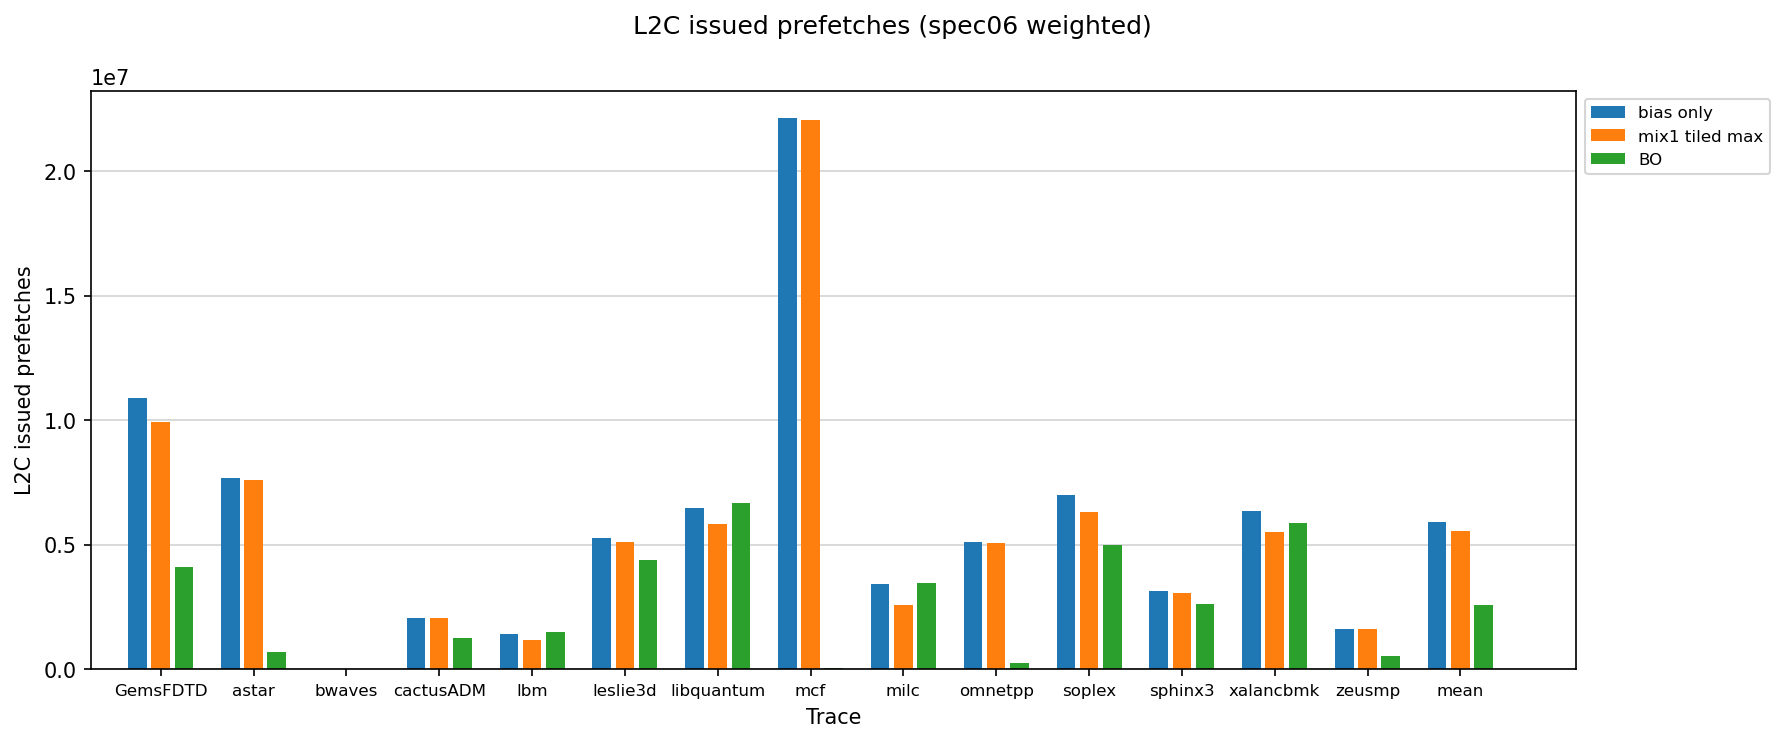

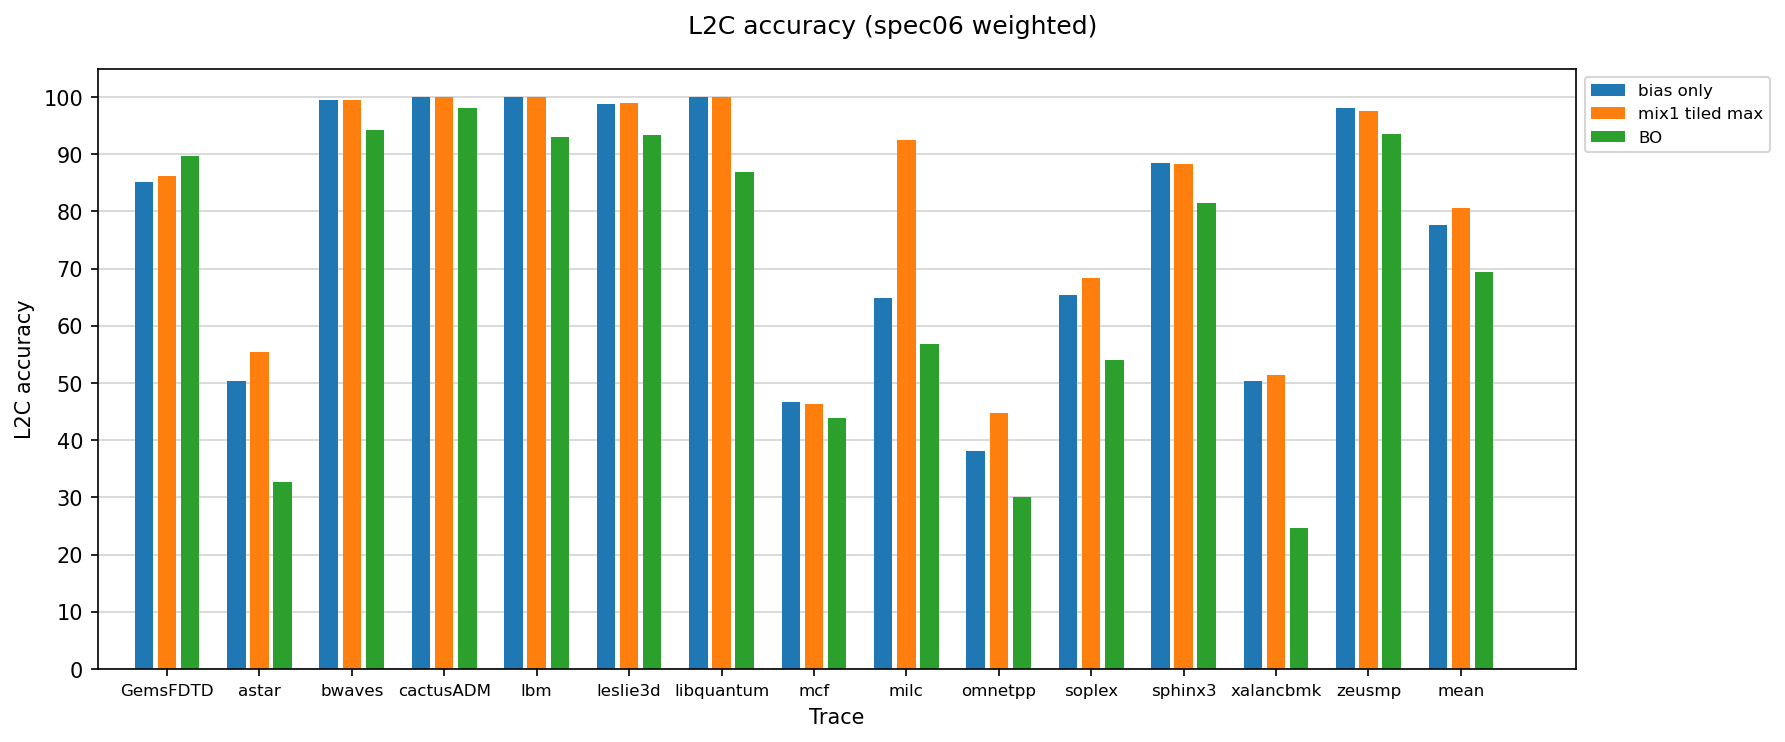

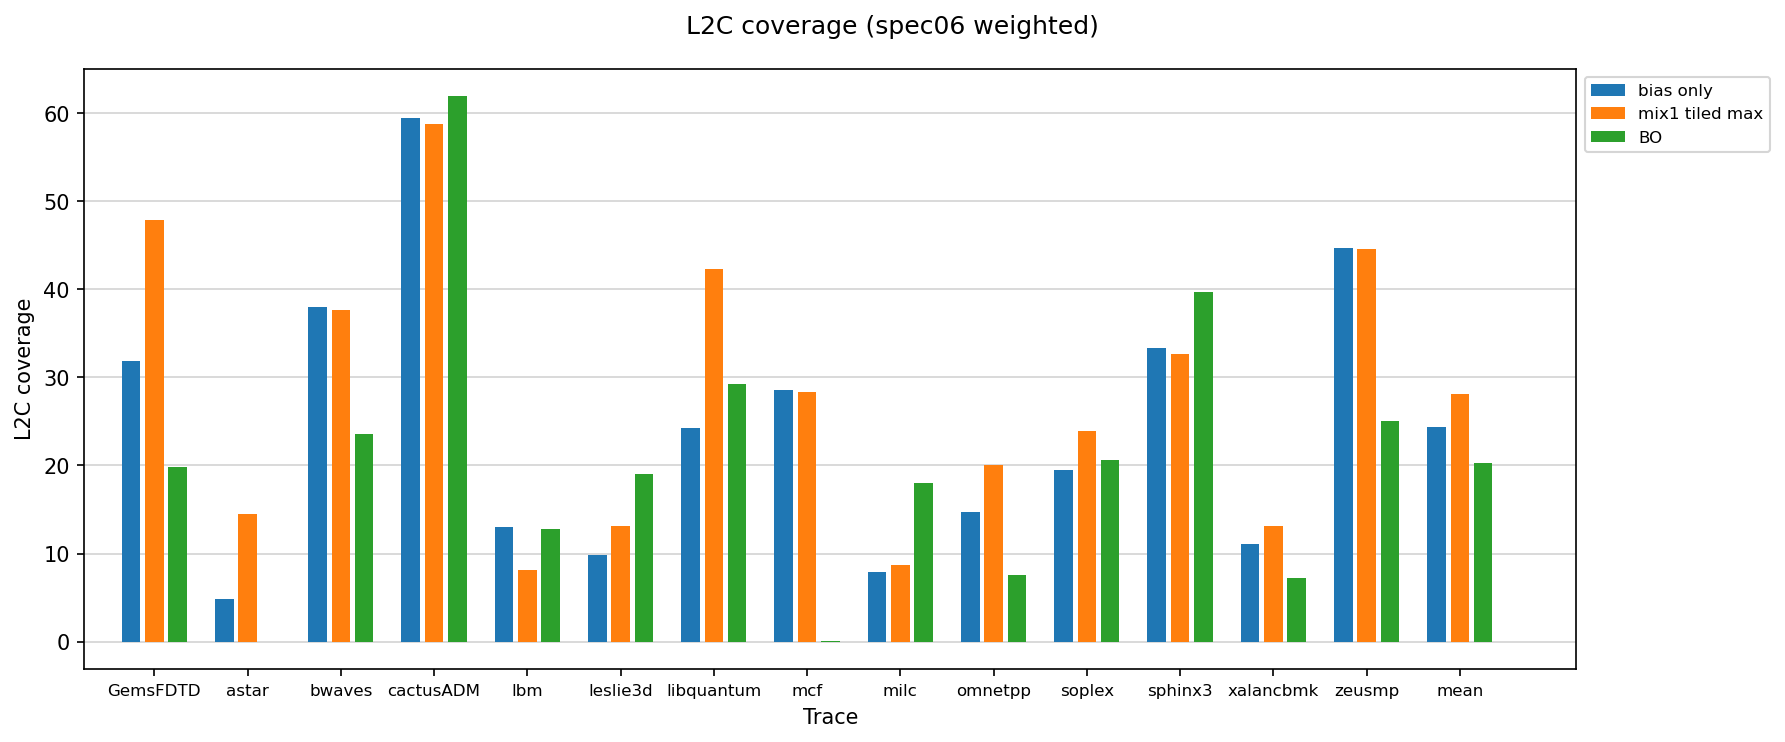

In [18]:
mix = 'Delta_Path, PC_Delta'
tiled_cmap = cm.get_cmap('Blues')
flat_cmap = cm.get_cmap('Greens')
mix1_df = {
    'mix1 flat sum': dfs['degree1_flat_sum'][mix],
    'mix1 flat sum (b)': dfs['degree1_flat_sum_biased'][mix],
    #'mix1 w sum global': dfs['degree1_flat_sum_weighted'][mix],
    'mix1 flat sum (w action)': dfs['degree1_flat_sum_weighted_action'][mix],
    'mix1 flat sum (n action)': dfs['degree1_flat_sum_normalized_action'][mix],
    'mix1 flat sum (n+ action)': dfs['degree1_flat_sum_normalizedplus_action'][mix],
    #'mix1 w sum state': dfs['degree1_flat_sum_weighted_state'][mix],
    #'mix1 w sum state-action': dfs['degree1_flat_sum_weighted_stateaction'][mix],
    # Baselines: Original Pythia, BO
    'mix1 tiled max': dfs['degree1_tiled_max'][mix], 
    'BO': dfs['degree1_baseline']['bo']
}
mix1_df_colors = {
    'mix1 flat sum': flat_cmap(0.25),
    'mix1 flat sum (b)': flat_cmap(0.4),
    #'mix1 w sum global': flat_cmap(0.55),
    'mix1 flat sum (w action)': flat_cmap(0.7),
    'mix1 flat sum (n action)': flat_cmap(0.85),
    'mix1 flat sum (n+ action)': flat_cmap(1.0),
    #'mix1 w sum state': flat_cmap(0.85),
    #'mix1 w sum state-action': flat_cmap(1.0),
    'mix1 tiled max': tiled_cmap(0.4),
    'BO': 'C4'
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    'loc': 'upper left',
    'bbox_to_anchor': (1, 1),
}
label_kwargs = {
    'fontsize': 8,
    'rotation': 0
}
plots.plot_everything(mix1_df, suites=suites, metrics=metrics, 
                      colors=mix1_df_colors, dpi=dpi, figsize=(12, 5),
                      legend_kwargs=legend_kwargs, label_kwargs=label_kwargs)

### mix2: Delta_Path, PC_Delta, Page

#### Tiled vs. flat

=== spec06 one_phase ===


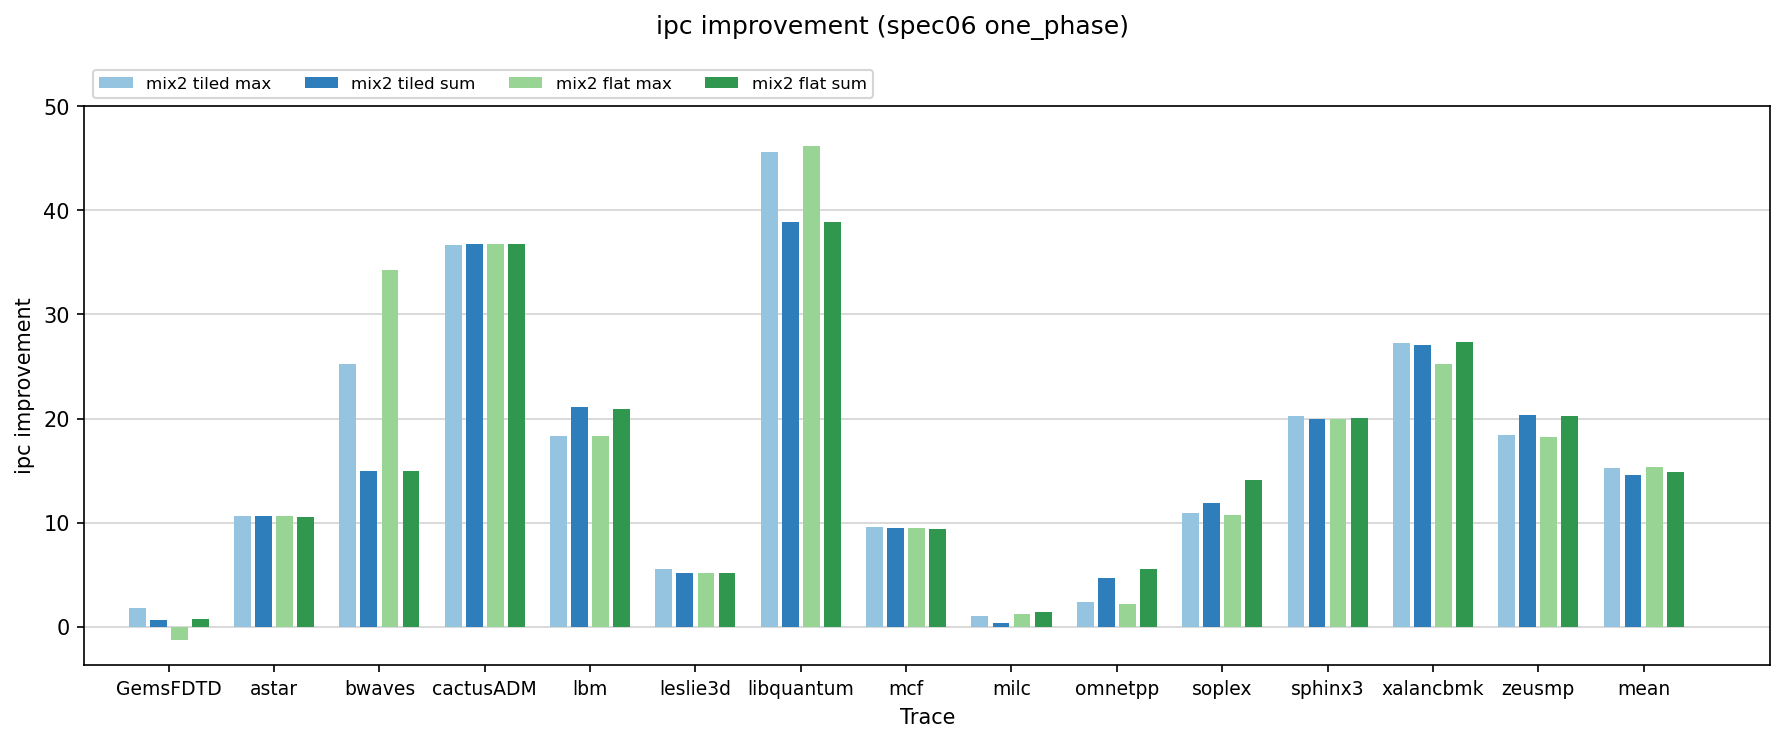

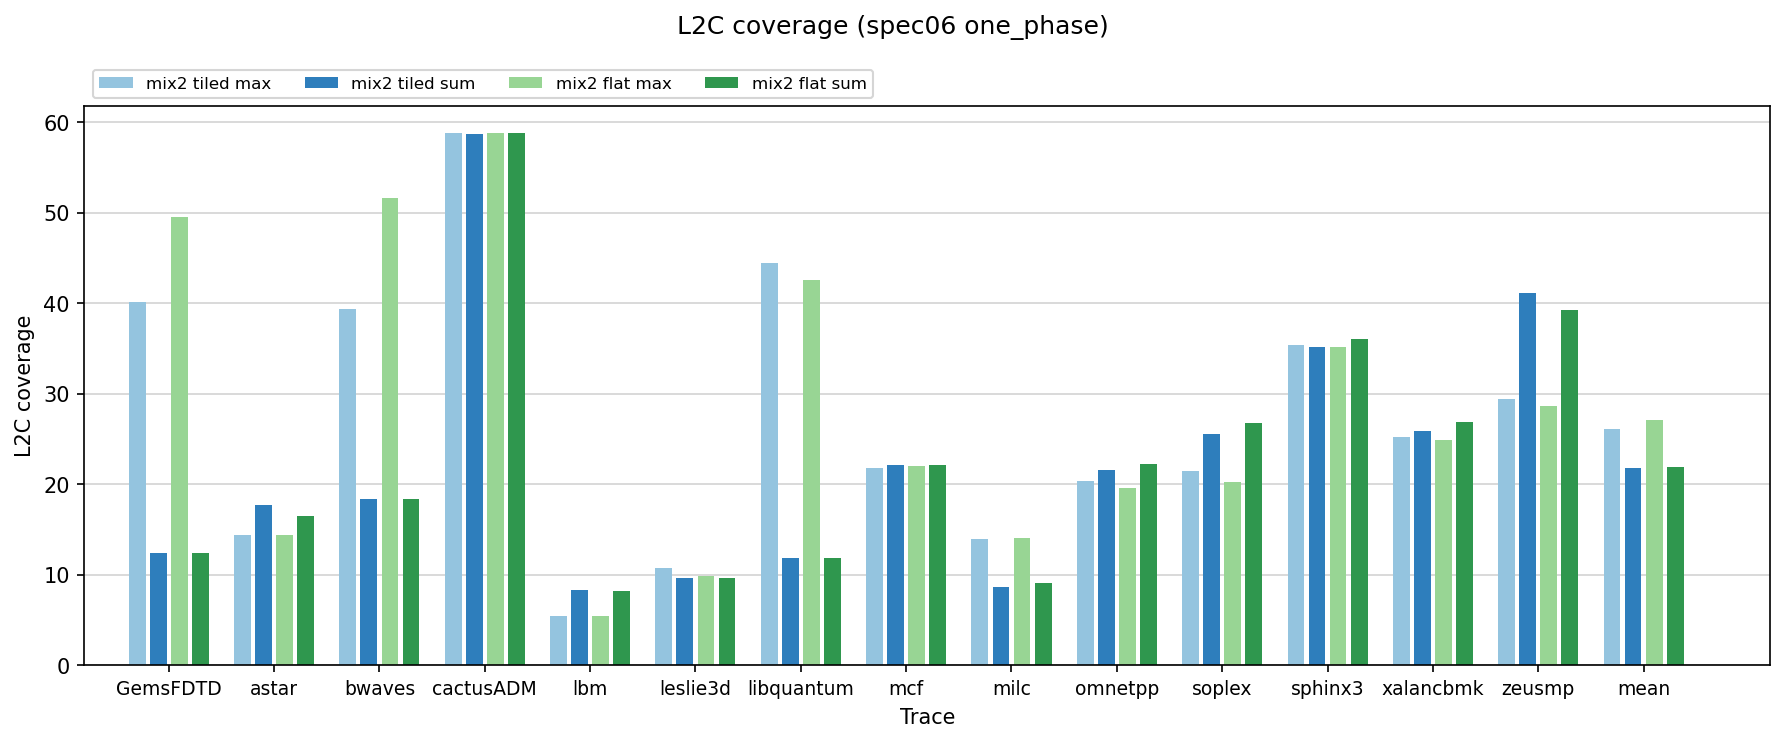

In [22]:
reload(plots)
tiled_cmap = cm.get_cmap('Blues')
flat_cmap = cm.get_cmap('Greens')
mix = 'Delta_Path, PC_Delta, Page'
mix2_tiled_df = {
    'mix2 tiled max': dfs['degree1_tiled_max'][mix],
    'mix2 tiled sum': dfs['degree1_tiled_sum'][mix],
    'mix2 flat max': dfs['degree1_flat_max'][mix],
    'mix2 flat sum': dfs['degree1_flat_sum'][mix],
}
mix2_tiled_df_colors = {
    'mix2 tiled max': tiled_cmap(0.4),
    'mix2 tiled sum': tiled_cmap(0.7),
    'mix2 flat max': flat_cmap(0.4),
    'mix2 flat sum': flat_cmap(0.7),
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 4,
    'loc': 'lower left',
    'bbox_to_anchor': (0, 1),
}
label_kwargs = {
    'fontsize': 9,
    'rotation': 0
}
plots.plot_everything(mix2_tiled_df, suites=suites, metrics=metrics, 
                      colors=mix2_tiled_df_colors, dpi=dpi, figsize=(12, 5),
                      legend_kwargs=legend_kwargs, label_kwargs=label_kwargs)

#### Pooling tweaks

=== spec06 one_phase ===


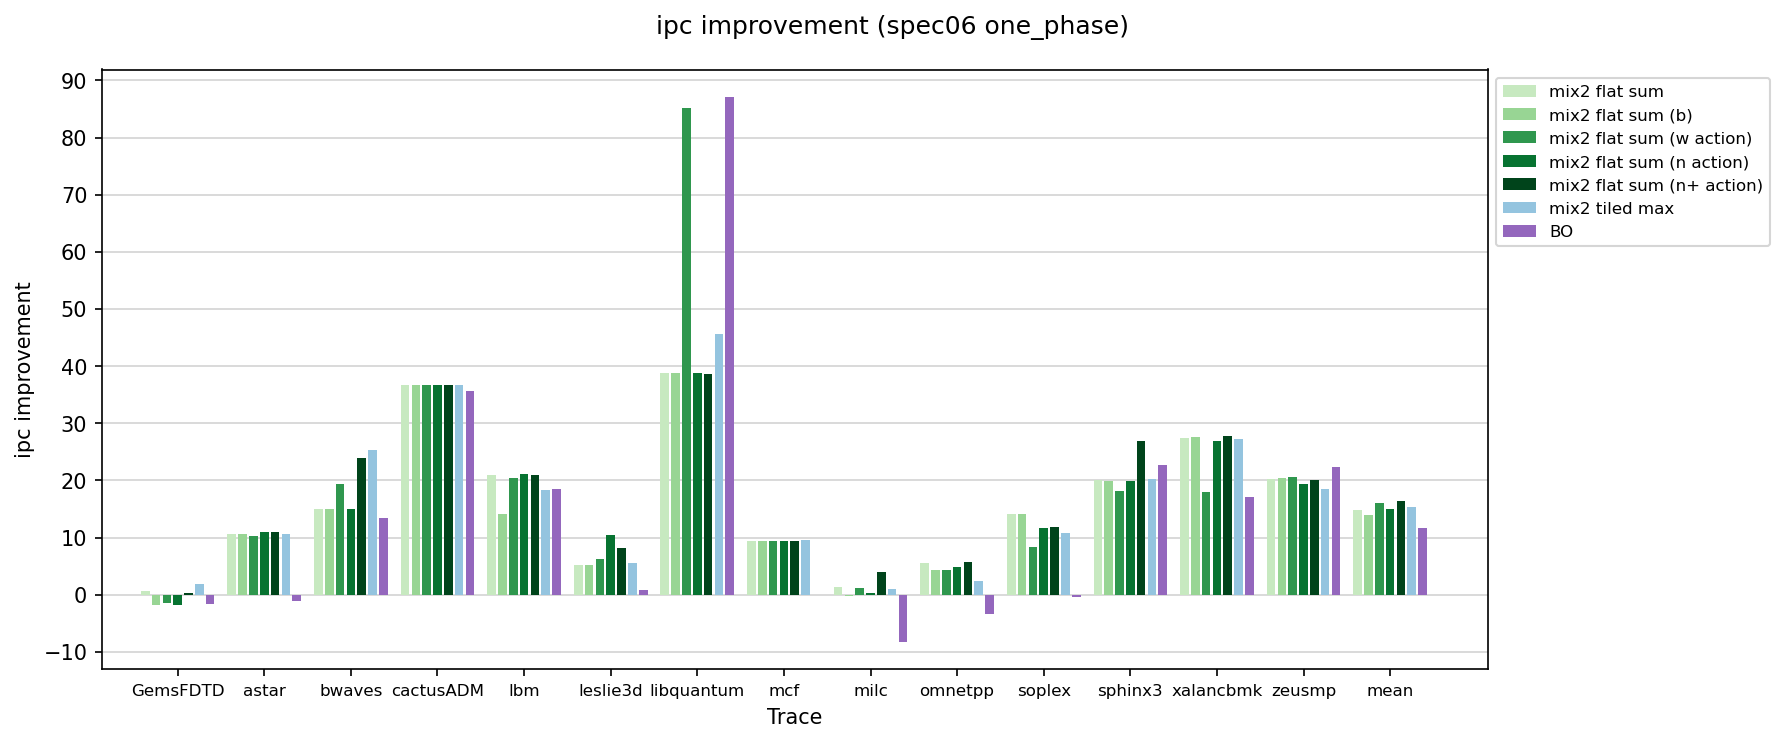

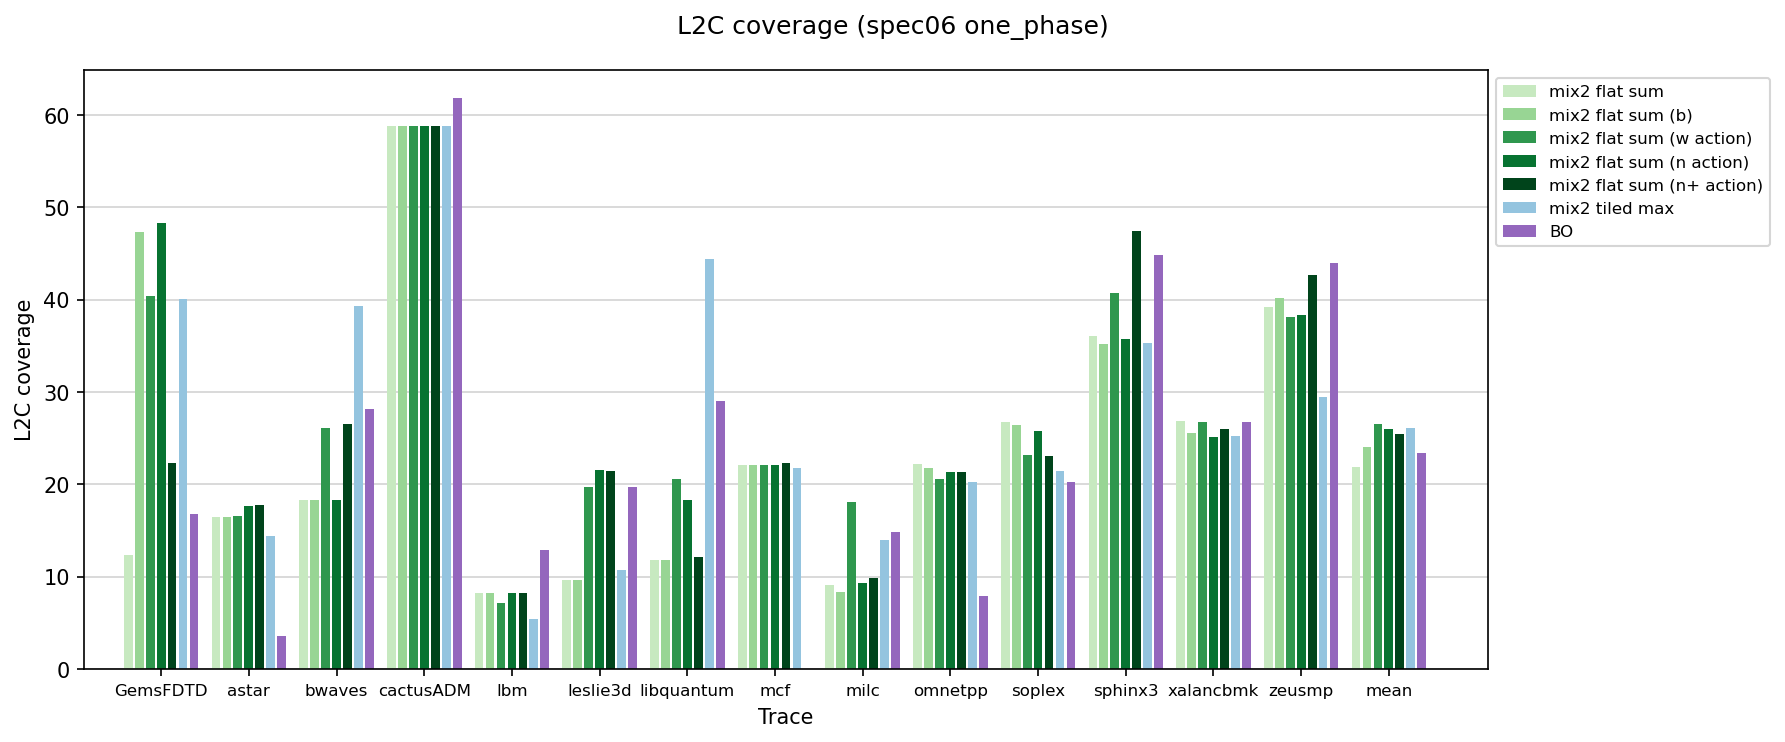

In [16]:
mix = 'Delta_Path, PC_Delta, Page'
tiled_cmap = cm.get_cmap('Blues')
flat_cmap = cm.get_cmap('Greens')
mix2_df = {
    'mix2 flat sum': dfs['degree1_flat_sum'][mix],
    'mix2 flat sum (b)': dfs['degree1_flat_sum_biased'][mix],
    #'mix1 w sum global': dfs['degree1_flat_sum_weighted'][mix],
    'mix2 flat sum (w action)': dfs['degree1_flat_sum_weighted_action'][mix],
    'mix2 flat sum (n action)': dfs['degree1_flat_sum_normalized_action'][mix],
    'mix2 flat sum (n+ action)': dfs['degree1_flat_sum_normalizedplus_action'][mix],
    #'mix1 w sum state': dfs['degree1_flat_sum_weighted_state'][mix],
    #'mix1 w sum state-action': dfs['degree1_flat_sum_weighted_stateaction'][mix],
    # Baselines: Original Pythia, BO
    'mix2 tiled max': dfs['degree1_tiled_max'][mix], 
    'BO': dfs['degree1_baseline']['bo']
}
mix2_df_colors = {
    'mix2 flat sum': flat_cmap(0.25),
    'mix2 flat sum (b)': flat_cmap(0.4),
    #'mix2 w sum global': flat_cmap(0.55),
    'mix2 flat sum (w action)': flat_cmap(0.7),
    'mix2 flat sum (n action)': flat_cmap(0.85),
    'mix2 flat sum (n+ action)': flat_cmap(1.0),
    #'mix2 w sum state': flat_cmap(0.85),
    #'mix2 w sum state-action': flat_cmap(1.0),
    'mix2 tiled max': tiled_cmap(0.4),
    'BO': 'C4'
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    'loc': 'upper left',
    'bbox_to_anchor': (1, 1),
}
label_kwargs = {
    'fontsize': 8,
    'rotation': 0
}
plots.plot_everything(mix2_df, suites=suites, metrics=metrics, 
                      colors=mix2_df_colors, dpi=dpi, figsize=(12, 5),
                      legend_kwargs=legend_kwargs, label_kwargs=label_kwargs)

# Tables

## Pythia features (max pooling)

In [12]:
tables.table_everything(max_pool_df, suites=suites, metrics=metrics)

=== spec06 weighted ===
ipc_improvement


,Offset,Delta,Address,PC_Address,Page,Delta_Path,PC,PC_Delta,mix1 (max),mix2 (max),mix3 (max)
run_name,,,,,,,,,,,
GemsFDTD_weighted,1.704236,0.980955,1.737554,1.738800,3.110915,1.252761,14.324508,14.401033,2.361902,2.392956,0.495525
astar_weighted,4.351846,4.323180,4.327404,4.333758,4.606516,5.789067,5.915350,5.930305,5.934839,5.956261,6.000273
bwaves_weighted,13.148032,15.938466,12.619485,12.619211,12.618829,16.155200,12.628127,13.919466,23.417631,21.038458,16.617703
cactusADM_weighted,35.240216,36.268027,36.109014,36.108933,36.092726,36.171613,36.208892,36.843149,36.109419,36.109419,36.109419
lbm_weighted,16.493243,19.750892,17.314573,17.314005,18.129499,19.828931,20.575334,20.016654,20.169920,17.574419,17.326167
leslie3d_weighted,3.121721,5.068063,5.958925,6.147686,5.972118,5.324074,6.220565,5.876851,5.694946,5.399821,5.115769
libquantum_weighted,26.551579,31.209699,26.551579,26.551579,26.551579,31.590326,31.348774,30.578628,47.157921,42.200445,26.670018
mcf_weighted,12.589558,12.585578,12.589082,12.590499,12.579524,12.594199,12.592069,12.629841,12.675215,12.670579,12.678799
milc_weighted,-0.198023,-1.312891,-1.318410,-1.335266,-1.376054,-1.044891,0.690217,-0.553171,0.035456,-1.423985,-0.171180


L2C_accuracy


,Offset,Delta,Address,PC_Address,Page,Delta_Path,PC,PC_Delta,mix1 (max),mix2 (max),mix3 (max)
run_name,,,,,,,,,,,
GemsFDTD_weighted,87.003226,84.293704,87.008937,87.012767,86.941204,84.843829,85.895501,86.111894,86.119546,86.508430,85.818679
astar_weighted,50.315272,49.505292,50.282346,50.277248,51.615586,55.366332,57.176982,56.142135,55.385654,55.438184,54.829879
bwaves_weighted,99.527512,99.204589,99.536037,99.535940,99.394655,99.271315,99.393259,99.282199,99.500796,99.536769,99.534632
cactusADM_weighted,99.940039,99.932520,99.944548,99.944488,99.944329,99.938990,99.942165,99.943578,99.944579,99.944579,99.944579
lbm_weighted,99.989426,99.984182,99.989022,99.989192,99.988241,99.988158,99.986860,99.990570,99.988320,99.989475,99.989305
leslie3d_weighted,98.572553,98.855911,98.711631,98.693544,98.794294,98.995969,98.816936,98.847977,98.942392,98.883339,98.884992
libquantum_weighted,99.998623,99.998364,99.998623,99.998623,99.998623,99.998763,99.998490,99.998500,99.998534,99.998605,99.998623
mcf_weighted,46.750086,46.752453,46.745998,46.747705,46.747562,46.752870,46.758076,46.818878,46.318049,46.323712,46.327177
milc_weighted,76.968903,71.007490,60.416545,60.361106,61.662219,79.325397,93.884689,81.630524,92.526881,69.227404,69.533442


L2C_coverage


,Offset,Delta,Address,PC_Address,Page,Delta_Path,PC,PC_Delta,mix1 (max),mix2 (max),mix3 (max)
run_name,,,,,,,,,,,
GemsFDTD_weighted,16.693268,40.292493,16.653988,16.659458,17.988340,43.224994,35.332333,30.610313,47.907793,39.791601,39.309229
astar_weighted,4.900619,4.892781,4.905338,4.895648,6.647236,13.932388,14.043782,15.066801,14.520211,14.687139,14.812722
bwaves_weighted,17.706646,34.534737,16.120557,16.123793,16.150111,32.513120,16.122071,16.903471,37.693990,34.169888,42.083900
cactusADM_weighted,58.561941,58.510176,58.750134,58.751809,58.788754,58.174900,58.772634,58.815772,58.768803,58.768803,58.768803
lbm_weighted,5.594972,8.111454,5.300488,5.299161,6.032209,8.154451,8.083078,7.988269,8.158119,6.361833,5.299167
leslie3d_weighted,21.856554,9.994567,22.557660,23.928370,15.026483,10.292503,10.128921,10.074505,13.148033,10.347704,9.530876
libquantum_weighted,10.865067,20.461427,10.865067,10.865067,10.865067,23.616802,21.465322,17.229296,42.306357,43.053324,10.882603
mcf_weighted,28.603891,28.605166,28.606941,28.607915,28.600970,28.605593,28.605692,28.764466,28.328016,28.335942,28.337577
milc_weighted,10.102704,6.847798,6.437502,6.406111,6.524819,11.181930,10.133248,8.190582,8.737581,8.024029,10.434403


## Pythia features (sum pooling)

In [13]:
tables.table_everything(sum_pool_df, suites=suites, metrics=metrics)

=== spec06 weighted ===
ipc_improvement


,mix1 sum,mix2 sum,mix3 sum
run_name,,,
GemsFDTD_weighted,3.589473,2.596226,1.399535
astar_weighted,5.939431,6.002189,5.935479
bwaves_weighted,14.668509,12.625839,12.622789
cactusADM_weighted,36.098456,36.137674,36.107850
lbm_weighted,20.019357,20.054565,20.298393
leslie3d_weighted,5.025574,5.096113,5.059269
libquantum_weighted,28.435894,26.551579,26.551579
mcf_weighted,12.602882,12.608581,12.595257
milc_weighted,0.636193,-0.129734,-0.278281


L2C_accuracy


,mix1 sum,mix2 sum,mix3 sum
run_name,,,
GemsFDTD_weighted,88.446991,88.975413,84.366105
astar_weighted,55.912948,55.575653,56.174376
bwaves_weighted,99.432943,99.516675,99.536037
cactusADM_weighted,99.944413,99.944282,99.944190
lbm_weighted,99.988387,99.988013,99.987749
leslie3d_weighted,99.054758,98.960604,98.996391
libquantum_weighted,99.998616,99.998623,99.998623
mcf_weighted,46.754588,46.755131,46.762378
milc_weighted,89.018988,82.431488,84.757619


L2C_coverage


,mix1 sum,mix2 sum,mix3 sum
run_name,,,
GemsFDTD_weighted,30.909373,30.206045,44.065131
astar_weighted,14.484667,15.738547,16.514417
bwaves_weighted,17.935400,16.133260,16.126576
cactusADM_weighted,58.795824,58.722343,58.784824
lbm_weighted,8.027496,8.028914,8.253138
leslie3d_weighted,9.593002,9.503141,9.537973
libquantum_weighted,19.210518,10.865067,10.865067
mcf_weighted,28.611005,28.612025,28.618277
milc_weighted,8.007319,7.400168,7.919449


## Pythia features (Various mixes vs. BO)
### mix1: Delta_Path, PC_Delta

In [28]:
tables.table_everything({**mix1_tiled_df, **mix1_df}, suites=suites, metrics=metrics)

=== spec06 one_phase ===
ipc_improvement


,mix1 tiled max,mix1 tiled sum,mix1 flat max,mix1 flat sum,mix1 flat sum (b),mix1 flat sum (w action),mix1 flat sum (w action norm),BO
run_name,,,,,,,,
GemsFDTD_109B,0.396118,4.259619,2.052612,18.053980,-0.451485,-1.311241,6.162336,-1.566467
astar_313B,10.748655,10.856114,10.732228,10.739757,10.980000,10.885546,10.765082,-1.163571
bwaves_1861B,27.292430,17.083303,29.744050,23.964037,39.554793,15.409434,21.455037,13.512929
cactusADM_734B,36.713149,36.702263,36.724036,36.794800,36.757785,36.703351,36.789356,35.597261
lbm_94B,21.355365,21.094381,20.940839,20.927504,23.063383,18.054772,20.991892,18.558072
leslie3d_1116B,5.154620,5.155775,5.183268,4.547922,5.068444,9.142283,11.989557,1.523444
leslie3d_94B,6.961426,4.997020,5.102636,5.328767,5.126081,9.187899,11.413934,0.225912
libquantum_1210B,54.024291,40.527174,50.624016,40.913098,41.622371,59.152502,40.821910,87.138647
mcf_46B,9.626446,9.442720,9.524715,9.429319,9.436263,9.434436,9.436141,0.039961


L2C_coverage


,mix1 tiled max,mix1 tiled sum,mix1 flat max,mix1 flat sum,mix1 flat sum (b),mix1 flat sum (w action),mix1 flat sum (w action norm),BO
run_name,,,,,,,,
GemsFDTD_109B,44.362114,15.026510,58.640071,24.137939,55.081838,44.850666,54.348567,16.799512
astar_313B,14.519640,14.735849,14.453463,14.973506,14.428507,16.237068,14.448440,3.586334
bwaves_1861B,43.322267,19.699441,51.505280,24.661849,33.467275,29.604833,26.824377,28.186255
cactusADM_734B,58.792491,58.840191,58.795157,58.808543,58.800319,58.777915,58.803381,61.840274
lbm_94B,8.444413,8.241490,8.233468,8.221190,12.325958,7.379435,8.081652,12.849335
leslie3d_1116B,9.964248,10.214476,9.991885,11.006144,10.074981,30.268146,21.879256,19.910527
leslie3d_94B,20.408173,9.296679,9.323396,9.973438,9.573700,37.934005,26.055750,19.550339
libquantum_1210B,43.273964,16.940841,32.224931,20.892931,27.207475,38.200280,21.428227,29.044092
mcf_46B,21.735015,22.124702,21.949485,22.127641,22.119070,22.115814,22.129336,0.047807


### mix2: Delta_Path, PC_Delta, Page

In [29]:
tables.table_everything({**mix2_tiled_df, **mix2_df}, suites=suites, metrics=metrics)

=== spec06 one_phase ===
ipc_improvement


,mix2 tiled max,mix2 tiled sum,mix2 flat max,mix2 flat sum,mix2 flat sum (b),mix2 flat sum (w action),mix2 flat sum (w action norm),BO
run_name,,,,,,,,
GemsFDTD_109B,1.843299,0.686455,-1.301788,0.722915,-1.760475,-1.432327,-1.714111,-1.566467
astar_313B,10.615871,10.685001,10.664467,10.589862,10.689792,10.258586,10.963573,-1.163571
bwaves_1861B,25.251654,14.929078,34.219724,14.929078,14.929078,19.377865,14.929078,13.512929
cactusADM_734B,36.713149,36.758873,36.757785,36.729479,36.757785,36.770849,36.775204,35.597261
lbm_94B,18.295945,21.156865,18.295945,20.930552,14.159440,20.352195,21.068854,18.558072
leslie3d_1116B,5.873370,5.180496,5.215844,5.208913,5.183499,8.195040,11.705153,1.523444
leslie3d_94B,5.154786,5.092775,5.121480,5.181080,5.138571,4.252233,9.217700,0.225912
libquantum_1210B,45.579317,38.831805,46.159948,38.831805,38.831805,85.256480,38.845995,87.138647
mcf_46B,9.621207,9.446010,9.495474,9.440649,9.441746,9.452711,9.432608,0.039961


L2C_coverage


,mix2 tiled max,mix2 tiled sum,mix2 flat max,mix2 flat sum,mix2 flat sum (b),mix2 flat sum (w action),mix2 flat sum (w action norm),BO
run_name,,,,,,,,
GemsFDTD_109B,40.079380,12.379045,49.532583,12.390294,47.286938,40.442139,48.299003,16.799512
astar_313B,14.395418,17.729903,14.392218,16.463482,16.500387,16.540309,17.680082,3.586334
bwaves_1861B,39.348809,18.364732,51.628502,18.364732,18.364732,26.140649,18.364732,28.186255
cactusADM_734B,58.792491,58.724544,58.800319,58.814328,58.800319,58.809961,58.810528,61.840274
lbm_94B,5.420651,8.245696,5.420651,8.217997,8.258920,7.159471,8.194082,12.849335
leslie3d_1116B,12.144793,9.989822,10.432157,9.992430,10.017117,20.887075,23.462934,19.910527
leslie3d_94B,9.323906,9.295958,9.305368,9.286530,9.336394,18.504764,19.627201,19.550339
libquantum_1210B,44.433774,11.857159,42.585435,11.857159,11.857159,20.610852,18.334272,29.044092
mcf_46B,21.747170,22.124919,22.006332,22.110188,22.120513,22.136775,22.117327,0.047807


In [16]:
tables.table_everything({**mix3_tiled_df, **mix3_df}, suites=suites, metrics=metrics)

=== spec06 weighted ===
ipc_improvement


,mix3 tiled max,mix3 tiled sum,mix3 flat max,mix3 flat sum,mix3 sum,mix3 w sum global,mix3 w sum action,mix3 w sum state,mix3 w sum state-action,BO
run_name,,,,,,,,,,
GemsFDTD_weighted,0.495525,1.399535,0.876132,1.187336,1.187336,1.236255,5.458994,2.677763,11.254993,-0.674942
astar_weighted,6.000273,5.935479,5.936756,5.926284,5.926284,5.901699,5.942925,5.864976,5.903266,-1.519958
bwaves_weighted,16.617703,12.622789,17.721928,12.625260,12.625260,12.625260,12.622627,12.625260,13.491156,10.882880
cactusADM_weighted,36.109419,36.107850,36.133962,36.138265,36.138265,36.138265,36.069533,36.138265,36.138101,34.888634
lbm_weighted,17.326167,20.298393,17.323702,20.585210,20.585210,17.311468,15.521429,17.491625,12.932426,17.391554
leslie3d_weighted,5.115769,5.059269,5.451988,5.119815,5.119815,5.109879,6.438604,4.893344,6.831088,0.710511
libquantum_weighted,26.670018,26.551579,26.688775,26.551579,26.551579,26.551579,67.987858,26.549531,43.598369,54.028418
mcf_weighted,12.678799,12.595257,12.608098,12.596211,12.596211,12.610119,12.610102,12.632974,12.609551,0.021858
milc_weighted,-0.171180,-0.278281,-1.643978,-0.626136,-0.626136,-1.509002,-0.655878,-1.276816,-0.872659,-8.788251


L2C_accuracy


,mix3 tiled max,mix3 tiled sum,mix3 flat max,mix3 flat sum,mix3 sum,mix3 w sum global,mix3 w sum action,mix3 w sum state,mix3 w sum state-action,BO
run_name,,,,,,,,,,
GemsFDTD_weighted,85.818679,84.366105,85.022816,84.601899,84.601899,86.149411,80.390331,88.304485,83.424834,89.662541
astar_weighted,54.829879,56.174376,51.727095,56.371002,56.371002,53.742974,56.346647,51.471274,55.001092,32.137227
bwaves_weighted,99.534632,99.536037,99.534138,99.540432,99.540432,99.540432,99.540336,99.540432,99.540113,94.065593
cactusADM_weighted,99.944579,99.944190,99.944582,99.944396,99.944396,99.944396,99.939784,99.944396,99.944391,98.126098
lbm_weighted,99.989305,99.987749,99.989305,99.988252,99.988252,99.989249,99.991075,99.985832,99.980858,92.979182
leslie3d_weighted,98.884992,98.996391,98.830393,98.936863,98.936863,98.865635,96.958325,98.914943,98.480687,93.273753
libquantum_weighted,99.998623,99.998623,99.998616,99.998623,99.998623,99.998623,99.998341,99.998623,99.998740,86.810246
mcf_weighted,46.327177,46.762378,46.608320,46.763549,46.763549,46.786756,46.768846,46.753963,46.743762,45.473241
milc_weighted,69.533442,84.757619,73.715080,83.985485,83.985485,58.517924,74.806735,77.154027,83.203959,57.140337


L2C_coverage


,mix3 tiled max,mix3 tiled sum,mix3 flat max,mix3 flat sum,mix3 sum,mix3 w sum global,mix3 w sum action,mix3 w sum state,mix3 w sum state-action,BO
run_name,,,,,,,,,,
GemsFDTD_weighted,39.309229,44.065131,42.843601,47.576232,47.576232,23.358230,33.476525,22.822098,29.544503,20.009322
astar_weighted,14.812722,16.514417,14.334361,16.576906,16.576906,16.424680,15.140501,14.259801,15.323242,0.089346
bwaves_weighted,42.083900,16.126576,35.363887,16.117015,16.117015,16.117015,16.130884,16.117015,18.936148,23.688201
cactusADM_weighted,58.768803,58.784824,58.773126,58.748614,58.748614,58.748614,59.110576,58.748614,58.748085,62.111270
lbm_weighted,5.299167,8.253138,5.299077,8.088962,8.088962,5.301387,9.548148,8.566553,10.439825,13.088035
leslie3d_weighted,9.530876,9.537973,10.716950,9.519792,9.519792,9.500685,17.091879,10.723167,14.785299,18.915760
libquantum_weighted,10.882603,10.865067,10.865482,10.865067,10.865067,10.865067,20.685363,10.867515,32.091711,29.563513
mcf_weighted,28.337577,28.618277,28.536101,28.619187,28.619187,28.712297,28.621114,28.647960,28.628806,0.018476
milc_weighted,10.434403,7.919449,11.439049,7.849257,7.849257,5.756307,16.440920,7.759269,11.651467,18.558878


### Mix comparison

In [17]:
mix_comp_df = {
    'mix1 w sum action': dfs['degree1_flat_sum_weighted_action']['Delta_Path, PC_Delta'],
    'mix2 w sum action': dfs['degree1_flat_sum_weighted_action']['Delta_Path, PC_Delta, Page'],
    'mix3 w sum action': dfs['degree1_flat_sum_weighted_action']['Delta_Path, Offset, PC_Delta, Page'],
}
tables.table_everything(mix_comp_df, suites=suites, metrics=metrics)

=== spec06 weighted ===
ipc_improvement


,mix1 w sum action,mix2 w sum action,mix3 w sum action
run_name,,,
GemsFDTD_weighted,4.591655,5.036603,5.458994
astar_weighted,5.882855,5.774974,5.942925
bwaves_weighted,13.928595,14.537840,12.622627
cactusADM_weighted,36.209938,36.144048,36.069533
lbm_weighted,17.398079,19.364445,15.521429
leslie3d_weighted,8.089127,6.263472,6.438604
libquantum_weighted,45.417569,67.991921,67.987858
mcf_weighted,12.594248,12.612793,12.610102
milc_weighted,0.979746,0.298093,-0.655878


L2C_accuracy


,mix1 w sum action,mix2 w sum action,mix3 w sum action
run_name,,,
GemsFDTD_weighted,81.603146,80.806691,80.390331
astar_weighted,56.193046,55.814734,56.346647
bwaves_weighted,99.185650,99.540171,99.540336
cactusADM_weighted,99.936199,99.944621,99.939784
lbm_weighted,99.987391,99.986482,99.991075
leslie3d_weighted,96.957530,97.600338,96.958325
libquantum_weighted,99.998585,99.998341,99.998341
mcf_weighted,46.741822,46.761729,46.768846
milc_weighted,79.637539,73.269284,74.806735


L2C_coverage


,mix1 w sum action,mix2 w sum action,mix3 w sum action
run_name,,,
GemsFDTD_weighted,35.631282,30.474271,33.476525
astar_weighted,14.637802,14.955005,15.140501
bwaves_weighted,26.672664,19.587494,16.130884
cactusADM_weighted,59.292973,58.758467,59.110576
lbm_weighted,7.154230,7.093729,9.548148
leslie3d_weighted,31.214872,17.235290,17.091879
libquantum_weighted,37.186813,20.683466,20.685363
mcf_weighted,28.605998,28.618977,28.621114
milc_weighted,16.317971,16.084351,16.440920
